In [1]:
using DataFrames
using CSV
using Glob
using Chain
using Statistics
using SimSpread
using ArgParse
using Base.Threads
using MLBase
using ProgressMeter
using AlgebraOfGraphics
using CairoMakie
using Plots
using StatsPlots
# include("getmetrics.jl")
using MLJ
using ProgressMeter
using StatsBase:sample
# using Base.Threads

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA ~/.julia/packages/CUDA/s0e3j/src/initialization.jl:70


In [2]:
function gobl(path::String)
    files = glob("*.out", path)
    df = DataFrame()
    
    for file in files
    # extract
    α = @chain file begin
        basename
        replace(".out" => "")
        split('.')
        last
        split('_')
        last
        end
    
    α_value = if length(α) > 2
            # startswith(α, "00")
              parse(Float64, α, ) / 100
          else
              parse(Float64, α) / 10
          end
 
    
    # file to df
    file_df = CSV.File(file, delim=",", header=["Fold", "Ligando", "Target", "Score", "TP"]) |> DataFrame
    
    # add alpha 
    file_df[!, "Alpha"] .= α_value
    
    append!(df, file_df)
    end
    
    return df
end

# open and format csv file data to compatible dataframe
function open_csv(path::String)
    files = glob("*.no_header.csv", path)
    df = DataFrame()
    
    for file in files
        file_df = CSV.read(file, DataFrame, header=["Ligando", "Target", "TP", "Score", "Alpha"]) 
        append!(df, file_df)
    end
    
    
    return df
end
    



;

In [3]:
""" ml functions for instantiation """




function log_class()
#     instantiate model
    return @iload LogisticClassifier pkg=MLJLinearModels verbosity=0
end

function rf_class()
#     instantiate model
     return @iload RandomForestClassifier pkg=DecisionTree verbosity=0
#     https://alan-turing-institute.github.io/MLJ.jl/dev/models/RandomForestClassifier_DecisionTree/#RandomForestClassifier_DecisionTree
end

function xgb_class()
#     instantiate model
     return @iload XGBoostClassifier pkg=XGBoost verbosity=0
end

function pca_dimred()
    return @iload PCA pkg=MultivariateStats verbosity=0
end

function sklearn_rf_class()
    return @iload RandomForestClassifier pkg=MLJScikitLearnInterface verbosity=0
#     https://alan-turing-institute.github.io/MLJ.jl/dev/models/RandomForestClassifier_MLJScikitLearnInterface/#RandomForestClassifier_MLJScikitLearnInterface
#     https://statistics.berkeley.edu/tech-reports/666
end

function catb_class()
    return @iload CatBoostClassifier pkg=CatBoost verbosity=0
end


function lin_reg()
    return @iload LinearRegressor pkg=MLJLinearModels verbosity=0
end

function lasso_reg()
    return @iload LassoRegressor pkg=MLJLinearModels verbosity=0
end

function rf_reg()
    return @iload RandomForestRegressor pkg=DecisionTree verbosity=0
end

function ridge_reg()
    return @iload RidgeRegressor pkg=MLJLinearModels verbosity=0
end

function xgb_reg()
    return @iload XGBoostRegressor pkg=XGBoost verbosity=0
end


function detconst_class()
    return @iload DeterministicConstantClassifier, package_name = MLJModels
end


# search for models compatible with model name, is native julia and based on keyword
function filter_models(y, X, args...)

    compatible_models = models(matching(X, y))

    filter(
    #     check for pure julia models
        m -> m.is_pure_julia && 
                 contains(m.docstring * m.name, args...),
        compatible_models
    )
end

;

In [4]:
""" base data manipulation, preparation, training and predictions """


# outputs all the scores of the dataframe into columns and calculates different estimators for each element of a vector of functions
function rescore(df::DataFrame, fxs::Vector{Function}, benchmark::String="0.2")
    symbs = []
    
    uniq = df[:, :Alpha]
    tcols = size(unique(uniq))[1] + ncol(df) - 3
    
    for f in fxs
        push!(symbs, String(Symbol(f)))
    end
    
    df_2 = @chain df begin
        groupby([:Ligando, :Target, :TP, :Alpha])    
        combine(:Score => sum => :Score)
        unstack(:Alpha, :Score)
        DataFrames.transform(AsTable(5:tcols) .=> ByRow.(fxs) .=> symbs)
        select(1:3, [benchmark], symbs)
    end
    return df_2
end

# trains ml model on the scores columns.
function train_rescore(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, model::Function=nothing, benchmark::String="0.2", categorical::Bool=false, isreg::Bool=false, ohe::Bool=false; args...)
    if model !== nothing
        fxm_name = String(Symbol(model))  
    #     train machine and make predictions
        if isreg == true
            _, yhat, params = regressor_machine_train_predict(df, df_train, model; args...)
        else
            if categorical == false
                _, yhat, _ = machine_train_predict(df, df_train, model; args...)
            else
                _, yhat, _ = machine_train_predict_categorical(df, df_train, model, ohe; args...)
            end
        end
        
#         apply function transformations to each row
        
        dft = lin_transform(df, fxs, benchmark)
        
#         add predictions to df
        dft[!, fxm_name] = yhat
    else
        dft = lin_transform(df, fxs, benchmark)
        
    end
    params = 0
    return dft
end


# trains vector of ml models on the score columns.
function train_rescore(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, model::Vector{Function}=nothing, benchmark::String="0.2", categorical::Bool=false, isreg::Bool=false, ohe::Bool=false; args...)
  
    dft = lin_transform(df, fxs, benchmark)
    if model !== nothing
        for m in model
    #     train machine and make predictions
            if isreg == true
                _, yhat, params = regressor_machine_train_predict(df, df_train, m; args...)
            else
                if categorical == false
                _, yhat, _ = machine_train_predict(df, df_train, m; args...)
                else
                _, yhat, _ = machine_train_predict_categorical(df, df_train, m, ohe; args...)
                end
            end
            m_name = String(Symbol(m))
            dft[!, m_name] = yhat
        end
    else
        dft = lin_transform(df, fxs, benchmark)
    end
    params = 0
    return dft
end



function lin_transform(df::DataFrame, fxs::Vector{Function}, benchmark::String)
    symbs = []
    
    uniq = df[:, :Alpha]
    tcols = size(unique(uniq))[1] + ncol(df) - 3
    
    for f in fxs
        push!(symbs, String(Symbol(f)))
    end
    
    df = rescore(df)
    
    df = @chain df begin
            DataFrames.transform(AsTable(4:tcols) .=> ByRow.(fxs) .=> symbs)
            select(1:3, [benchmark], symbs)
        end
    return df
end


# lin transform for dimensionality reduction projections
function lin_transform(df::DataFrame, fxs::Vector{Function})
    symbs = []
    for f in fxs
        push!(symbs, String(Symbol(f)))
    end
    tcols = ncol(df)
    df = @chain df begin 
        DataFrames.transform(AsTable(1:tcols) .=> ByRow.(fxs) .=> symbs)
        select(symbs)
    end
    return df
end


# format dataframes to match standard format.
function rescore(df::DataFrame)
    df = @chain df begin
        select([:Ligando, :Target, :Score, :TP, :Alpha])
        groupby([:Ligando, :Target, :TP, :Alpha])    
        combine(:Score => sum => :Score)
        unstack(:Alpha, :Score)
    end
#     remove both spaces
    df[!, :Target] = strip.(df[!, :Target])
    return df
end



function machine_train_predict_categorical(df::DataFrame, df_train::DataFrame, model, ohe::Bool=false; args...)  
    cat = :Target
    y, X, yt, Xt, Xlabel =  get_cat_vector(df, df_train)
#         model instantiate
    Model = model
    p2 = Model()

    if ohe == true
#         when model requires onehot encoding i.e. logistic regression

#         onehot encode Multiclass vector on concatenated features df to continuous Float64
        Xtone = onehot(Xlabel)
#         split concatenated features df in train and test set        
        Xtest, Xtrain = split_cat_vector(Xt, Xtone)
#         build and fit machine to train features
        mach = machine(p2(;args...), Xtrain, yt) |> fit!
#         predit on test features
        yhat = predict_mode(mach, Xtest)
        
    else
        #         else coerce the concatenated features dataframe categorical vector to orderedfactor

#         coerce Multiclass vector on concatenated features df to OrderedFactor
        Xorf = get_ordered_factor(Xlabel)
#         split concatenated features df in train and test set
        Xtest, Xtrain = split_cat_vector(Xt, Xorf)
#         build and fit machine to train features
        mach = machine(p2(;args...), Xtrain, yt) |> fit!
#         predit on test features
        yhat = predict_mode(mach, Xtest)
    end
    params = nothing
    return y, yhat, params
end
    
    
function machine_train_predict(df::DataFrame, df_train::DataFrame, model; args...)

     yt, Xt =  machine_input(df_train; rng=123)

    # train machine and get parameters
    Model = model
    p2 = Model()
#     class weights
    # w = map(x -> if x == 0 x = 180 else 1 end , yt)
    m1 = machine(p2(;args...), Xt, yt, w) |> fit!
    params = nothing
    # params = fitted_params(m1)

#     prepare test set for machine predictions
    y, X =  machine_input(df)

#     predict
    yhat = MLJ.predict_mode(m1, X)
    return y, yhat, params
end
    

function machine_train_predict_normal(df::DataFrame, df_train::DataFrame, model, r=1, ss::Int64=500; args...)

    yt, Xt =  machine_input_normalized(df_train, r, ss; rng=123)
    y, X =  machine_input_normalized(df)
    # train machine and get parameters
    Model = model
    p2 = Model()
#     class weights
    # w = map(x -> if x == 0 x = 180 else 1 end , yt)
    m1 = machine(p2(;args...), Xt, yt) |> fit!
    params = nothing
    # params = fitted_params(m1)

#     predict
    yhat = MLJ.predict_mode(m1, X)
    return y, yhat, params
end


function regressor_train_predict_normal(df::DataFrame, df_train::DataFrame, model, r=1, ss::Int64=500; args...)
    
    # Prepare dataset
    yt, Xt =  machine_input_normalized(df_train, r, ss; rng=123)
    y, X =  machine_input_normalized(df)
    yt = coerce(yt, Continuous)
    y = coerce(y, Continuous)
    
    
    # train machine and get parameters
    Model = model
    model = Model()
    m1 = machine(model(;args...), Xt, yt) |> fit!
    params = nothing

#     predict
    yhat = MLJ.predict_mode(m1, X)
    return y, yhat, params
end



function get_cat_vector(df::DataFrame, df_train::DataFrame)
    # categorical vector
    y, X =  machine_input(df, :Target)
    yt, Xt =  machine_input(df_train, :Target, rng=123)
    Xlabel = vcat(Xt, X)
    return y, X, yt, Xt, Xlabel
end

function split_cat_vector(Xt::DataFrame, Xlabel::DataFrame)
    Xtrain = Xlabel[1:size(Xt)[1] , :]
    Xtest = Xlabel[(size(Xt)[1] + 1):end , :]
    return Xtest, Xtrain
end

function get_ordered_factor(Xlabel::DataFrame)
    Xrf = coerce(Xlabel, :Target => OrderedFactor)
    return Xrf
end


function machine_input(df::DataFrame, cat=nothing; args...)
    df = rescore(df)
    if cat !== nothing
        y, X = prepare_machine(df, cat; args...)
    else
        y, X = prepare_machine(df; args...)
    end
    return y, X
end    
 

function machine_input_normalized(df::DataFrame, r=nothing, ss=nothing; args...)
    if ss !== nothing 
        y, X = prepare_machine(balance_normalized(df, r, ss); rng=123)
    else
        y, X = prepare_machine(normalize_scores(df))
    end
    return y, X
end



# when preparing categorical features
function prepare_machine(df::DataFrame, cat; args...)
    #     this is for scitype compatibility with machine
    df = select(df, cat, 3:ncol(df))
    df[!, 3:end] = convert.(Float64, df[!, 3:end])
    df = coerce(df, :TP=>Multiclass, cat=>Multiclass)
    y, X = unpack(df, ==(:TP); args...)
    return y, X
end

# when preparing numerical features   
function prepare_machine(df::DataFrame; args...)
    df = select(df, 3:ncol(df)) 
    df[!, 2:end] = convert.(Float64, df[!, 2:end])
    df = coerce(df, :TP=>Multiclass)
    y, X = unpack(df, ==(:TP); args...)
    return y, X
end

# function prepare_machine_testm(df::DataFrame; args...)
#     #     this is for scitype compatibility with machine

#     df = select(df, 3:ncol(df)) 
#     df[!, :tptest] = df[!, :TP]
#     df[!, 2:(ncol(df) - 1)] = convert.(Float64, df[!, 2:(ncol(df) - 1)])
#     df = coerce(df, :TP=>Multiclass, :tptest=>OrderedFactor)
#     y, X = unpack(df, ==(:TP); args...)
#     return y, X
# end

prepare_machine (generic function with 2 methods)

In [5]:
""" normalization and balancing ml pipelines """


function normalize_train_rescore(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, model::Function=nothing, benchmark::String="0.2", isreg::Bool=false, r=1, ss::Int64=500; args...)
    if model !== nothing
        fxm_name = String(Symbol(model))  
    #     train machine and make predictions
        if isreg == true
            _, yhat, params = regressor_train_predict_normal(df, df_train, model, r , ss; args...)
        else
            _, yhat, _ = machine_train_predict_normal(df, df_train, model, r, ss; args...)

        end
        
#         apply function transformations to each row
        
        dft = lin_transform(df, fxs, benchmark)
        
#         add predictions to df
        dft[!, fxm_name] = yhat
    else
        dft = lin_transform(df, fxs, benchmark)
        
    end
    params = 0
    return dft
end


# trains vector of ml models on the score columns.
function normalize_train_rescore(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, model::Vector{Function}=nothing, benchmark::String="0.2", isreg::Bool=false, r=1, ss::Int64=500 ; args...)
  
    
    if model !== nothing
        dft = lin_transform(df, fxs, benchmark)
        for m in model
    #     train machine and make predictions
            if isreg == true
                _, yhat, params = regressor_train_predict_normal(df, df_train, m, r , ss; args...)
            else
         
                _, yhat, _ = machine_train_predict_normal(df, df_train, m, r, ss; args...)
            end
            
            m_name = String(Symbol(m))
            dft[!, m_name] = yhat
        end
    else
        dft = lin_transform(df, fxs, benchmark)
    end
    params = 0
    return dft
end

normalize_train_rescore (generic function with 11 methods)

In [6]:
""" normalization and balancing functions """

function normalize_scores(df::DataFrame)
    df2 = @chain df begin
        select(:Ligando, :Score)
        groupby(:Ligando)
        combine(:Score => maximum => :Max)
    end

    dfpren = leftjoin(rescore(df), df2, on=:Ligando)

    df_perct = copy(dfpren)
    for n in 4:(ncol(df_perct) - 1)
        df_perct[!, n] .= (dfpren[!, n] ./ dfpren[!,:Max])
    end
    select!(df_perct, Cols(1:(ncol(df_perct)-1)))
    return df_perct
end


function balance_sample(df::DataFrame)
    ss = 1000
    df = rescore(df)
    df_positives = filter(:TP => n -> n == 1, df)
    df_negatives = filter(:TP => n -> n == 0, df)

    pos_sample_rows = sample(1:nrow(df_positives), ss, replace=false)
    neg_sample_rows = sample(1:nrow(df_negatives), ss, replace=false)
    pos_sample = df_positives[pos_sample_rows, :]
    neg_sample = df_negatives[neg_sample_rows, :]
    df_train =vcat(pos_sample, neg_sample)
    return df_train
end


function balance_sample(df::DataFrame, n_samples::Int64, ss::Int64=500)
    df = rescore(df)
    df_train = DataFrame()
    df_positives = filter(:TP => n -> n == 1, df)
    df_negatives = filter(:TP => n -> n == 0, df)
    
    i = 1
    while i <= n_samples
        pos_sample_rows = sample(1:nrow(df_positives), ss, replace=false)
        pos_sample = df_positives[pos_sample_rows, :]
        neg_sample_rows = sample(1:nrow(df_negatives), ss, replace=false)
        neg_sample = df_negatives[neg_sample_rows, :]  
        df_conc =vcat(pos_sample, neg_sample)
        append!(df_train, df_conc)
        i += 1
    end
    return df_train
end

function balance_normalized(df::DataFrame, r=1, ss::Int64=500)
    df = normalize_scores(df)
    df_positives = filter(:TP => n -> n == 1, df)
    df_negatives = filter(:TP => n -> n == 0, df)

    pos_sample_rows = sample(1:nrow(df_positives), (ss * Int(r)), replace=false)
    neg_sample_rows = sample(1:nrow(df_negatives), ss, replace=false)
    pos_sample = df_positives[pos_sample_rows, :]
    neg_sample = df_negatives[neg_sample_rows, :]
    df_train =vcat(pos_sample, neg_sample)
    return df_train
end

balance_normalized (generic function with 3 methods)

In [7]:
""" dimensionality reduction and regressor machine functions """

# with dimensionality reduction
function dim_train_rescore(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, model::Vector{Function}=nothing, benchmark::String="0.2", fxd::Function=nothing, isreg::Bool=false; args...)
    dft = lin_transform(df, fxs, benchmark)
    if model !== nothing
        for m in model

            if fxd !== nothing
    #             dimension reduction and then train machine and predict
                if isreg == true
                    y, yhat, params = regressor_dimension_reduction_train(df, df_train, m, fxd; args...)
                else
                    y, yhat, params  = dimension_reduction_train(df, df_train, m, fxd; args...)
                end

            else
                if isreg == true
                    y, yhat, params = regressor_machine_train_predict(df, df_train, m; args...)
                else
                   y, yhat, params = machine_train_predict(df, df_train, m; args...)
                end

            end
            m_name = String(Symbol(m))
            dft[!, m_name] = yhat
        end
        
    else
        dft = lin_transform(df, fxs, benchmark)
        
    end
    params = 0
    return dft, params
end



function dimension_reduction_rescore(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, fxd, benchmark::String="0.2", dimtransform=false; args...)

#     dimension reduction
    X, _ = dimension_reduction_transform(df, df_train, fxd; args...)
  
    dft = lin_transform(df, fxs, benchmark)
    
    if dimtransform == true
        mod = String(Symbol(fxd))
        X = lin_transform(X, fxs)
        for i in names(X)
            dft[!, mod * "_" * i] = X[!, i]
        end
        
    else
        
        j = range(1, ncol(X), step=1)
        for i in j
            colname = "x$i"
            x = X[!, colname]
            dft[!, colname] = x
        end
    end
    
    return dft
end




function dimension_reduction_train(df::DataFrame, df_train::DataFrame, model, fxd; args...)
    y_train, X_train = machine_input(df_train)  
    y, X =  machine_input(df)
    # Dim reduction to features
    X, X_train = dimension_reduction_transform(df, df_train, fxd; maxoutdim=5)

    Model = model
    model = Model()
    m1 = machine(model(;args...), X_train, y_train) |> fit!
    params = fitted_params(m1)   
#   predict
    yhat = MLJ.predict_mode(m1, X)
    return y, yhat, params
end


function regressor_dimension_reduction_train(df::DataFrame, df_train::DataFrame, model, fxd; args...)
    y_train, X_train = machine_input(df_train)  
    y_train = coerce(y_train, Continuous)
    y, X =  machine_input(df)
    y = coerce(y, Continuous)
    # Dim reduction to features
    X, X_train = dimension_reduction_transform(df, df_train, fxd; maxoutdim=5)

    Model = model
    model = Model()
    m1 = machine(model(;args...), X_train, y_train) |> fit!
    params = fitted_params(m1)
    
    
#   predict
    yhat = MLJ.predict_mode(m1, X)
    return y, yhat, params
end


# Dimensionality reduction wit
function dimension_reduction_transform(df::DataFrame, df_train::DataFrame, fxd; args...)
    _, X_train = machine_input(df_train)    
    dModel = fxd
    dmodel = dModel()
    dm = machine(dmodel(;args...), X_train) |> fit!
    X_train = MLJ.transform(dm, X_train)
#             prepare test set
    _, X =  machine_input(df)
#             transform test set
    X = MLJ.transform(dm, X)
    return X, X_train
end


    
function regressor_machine_train_predict(df::DataFrame, df_train::DataFrame, model; args...)

     y, X =  machine_input(df_train; rng=123)
     y = coerce(y, Continuous)

    # train machine and get parameters
    Model = model
    model = Model()
    m1 = machine(model(;args...), X, y) |> fit!
    params = nothing

#     prepare test set for machine predictions
    y, X =  machine_input(df)
    y = coerce(y, Continuous)
#     predict
    yhat = MLJ.predict_mode(m1, X)
    return y, yhat, params
end

# p1 = X -> coerce(X, :Target => OrderedFactor)
# p2 = RandomForestClassifier
# pp = p1 |> p2





regressor_machine_train_predict (generic function with 1 method)

In [8]:
""" performance functions """


function evaluate(df::DataFrame)
    df_f = DataFrame()
    
    symbs = []
    # for f in fxs
    #     push!(symbs, String(Symbol(f)))
    # end
    # push!(symbs, benchmark)
    
    for name in names(df[:, 4:end])
        push!(symbs, name)
    end
    
#     if using ml model, and model function is provided, add function name 
    # if yhat != "0"
    #     push!(symbs, String(Symbol(yhat)))
    # else
        
    # end
    
    for metric in symbs
        df_t = @chain df begin
            select(["Ligando", "Target", "TP" , metric])
            rename!(4 => :Score)
        end
        
        df_m = getperformance(df_t)
        df_m.groupid = replace(df_m.groupid, missing => metric)
        append!(df_f, df_m)
    end
    
    return df_f
end


function plotmetrics(df::DataFrame, benchmark::String="0.2")
    gr()
        
    df_plot = @chain df begin
        stack(names(df[:, 2:end]), :groupid)
        unstack(:groupid, :value)
        rename!(:variable => :metric)
    end
    
    df_perct = copy(df_plot)
    for n in 2:ncol(df_perct)
    df_perct[:, n] .= (df_plot[:, n] .- df_plot[:,benchmark]) ./ df_plot[:,benchmark]
    end
    
    plot1 = @df df_plot groupedbar(
    :metric,
    cols(2:ncol(df_plot)),
    bar_width=0.7,
    framestyle = :box,
    lw = 0,
    guidefontsize = 8,
    )
    
    plot2 = @df df_perct groupedbar(
    :metric,
    cols(2:ncol(df_plot)),
    bar_width=0.7,
    framestyle = :box,
    lw = 0,
    guidefontsize = 8,
    )
    
    return plot1, plot2, df_plot, df_perct
end;

# getmetrics.jl functions

function getperformance(
    df::DataFrame;
    ycol::String="TP",
    yhatcol::String="Score",
#   estoy agregando columna ligandos para funcion r@ y p@
    ligcol::String="Ligando"
)
    # Initialize function
    score = convert(Vector{Float64}, df[!, yhatcol])
    tp = convert(Vector{Bool}, df[!, ycol])
#   grouping para la nueva funcion
    grouping = df[!, ligcol]

    # Generate confusion matrix and common metrics
    thresholds = sort(unique(score))

    confusion =MLBase.roc(tp, score, thresholds)
    recalls = SimSpread.recall.(confusion)
    precisions = SimSpread.precision.(confusion)
    tprs =MLBase.true_negative_rate.(confusion)
    fprs =MLBase.false_negative_rate.(confusion)

    # Standard metrics
    auprc = SimSpread.AuPRC(tp, score)
    auroc = SimSpread.AuROC(tp, score)

    # Early recognition
    bedroc = SimSpread.BEDROC(tp, score)
#     agregando implementacion de r@20 y p@20 de update de SimSpread 03/04/2023
    r20 = SimSpread.recallatL(tp, score, grouping, 20)
    p20 = SimSpread.precisionatL(tp, score, grouping, 20)

    # Binary metrics
    f1 = SimSpread.maxperformance(confusion, SimSpread.f1score)
    bacc = SimSpread.maxperformance(confusion, SimSpread.balancedaccuracy)
    acc = SimSpread.maxperformance(confusion, SimSpread.accuracy)
    mcc = SimSpread.maxperformance(confusion, SimSpread.mcc)

    return DataFrame(
        groupid=[missing],
        AuROC=[auroc],
        AuPRC=[auprc],
        BEDROC=[bedroc],
        r20 = [r20],
        p20 = [p20],
        f1=[f1],
        bacc=[bacc],
        acc=[acc],
        mcc = [mcc],
    )
end

function getperformance(
    df::DataFrame,
    groupby::String;
    ycol::String="TP",
    yhatcol::String="Score"
)
    # Initialize function
    grouper = df[!, groupby]
    alltp = convert(Vector{Bool}, df[!, ycol])
    allscore = convert(Vector{Float64}, df[!, yhatcol])

    # Evaluate performance per group
    groupperformance = DataFrame()
    for groupᵢ in unique(grouper)
        # Get group scores and true-positive state
        tp = alltp[grouper.==groupᵢ]
        score = allscore[grouper.==groupᵢ]

        # Confusion matrix
        thresholds = sort(unique(score))

        confusion =MLBase.roc(tp, score, thresholds)
        recalls = SimSpread.recall.(confusion)
        precisions = SimSpread.precision.(confusion)
        tprs =MLBase.true_negative_rate.(confusion)
        fprs =MLBase.false_negative_rate.(confusion)

        # Standard metrics
        auprc = SimSpread.AuPRC(tp, score)
        auroc = SimSpread.AuROC(tp, score)

        # Early recognition
        bedroc = SimSpread.BEDROC(tp, score)
        # r20 = SimSpread.performanceatL(tp, score, SimSpread.recall)
        # p20 = SimSpread.performanceatL(tp, score, SimSpread.precision)

        # Binary metrics
        f1 = SimSpread.maxperformance(confusion, SimSpread.f1score)
        bacc = SimSpread.maxperformance(confusion, SimSpread.balancedaccuracy)
        acc = SimSpread.maxperformance(confusion, SimSpread.accuracy)
        # mcc = SimSpread.maxperformance(confusion, SimSpread.mcc)

        append!(
            groupperformance,
            DataFrame(
                groupid=[groupᵢ],
                AuROC=[auroc],
                AuPRC=[auprc],
                BEDROC=[bedroc],
                # r20 = [r20],
                # p20 = [p20],
                f1=[f1],
                bacc=[bacc],
                acc=[acc],
                # mcc = [mcc],
            )
        )
    end

    return groupperformance
end


getperformance (generic function with 2 methods)

In [9]:
""" testing functions with TP as a feature for training """

# trains ml model on the scores columns.
function testm_train_rescore(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, model::Function=nothing, benchmark::String="0.2"; args...)

    if model !== nothing
        fxm_name = String(Symbol(model))  
    #     train machine and make predictions
        _, yhat, _ = machine_train_predict_testm(df, df_train, model; args...)
        
        dft = lin_transform(df, fxs, benchmark)
        
#         add predictions to df
        dft[!, fxm_name] = yhat
    else
        dft = lin_transform(df, fxs, benchmark)
        
    end
    return dft
end


# trains vector of ml models on the score columns.
function testm_train_rescore(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, model::Vector{Function}=nothing, benchmark::String="0.2"; args...)
  
    dft = lin_transform(df, fxs, benchmark)
    if model !== nothing
        for m in model
    #     train machine and make predictions
            _, yhat, _ = machine_train_predict_testm(df, df_train, m; args...)
            m_name = String(Symbol(m))
            dft[!, m_name] = yhat
        end
    else
        dft = lin_transform(df, fxs, benchmark)
    end
    return dft
end


function machine_train_predict_testm(df::DataFrame, df_train::DataFrame, model; args...)
     yt, Xt =  machine_input_testm(df_train; rng=123)

    # train machine and get parameters
    Model = model
    p2 = Model()
    m1 = machine(p2(;args...), Xt, yt) |> fit!
    params = nothing
    # params = fitted_params(m1)

#     prepare test set for machine predictions
    y, X =  machine_input_testm(df)

#     predict
    yhat = MLJ.predict_mode(m1, X)
    return y, yhat, params
end


function machine_input_testm(df::DataFrame; args...)
y, X = prepare_machine_testm(rescore(df); args...)
end  


function prepare_machine_testm(df::DataFrame; args...)
    #     this is for scitype compatibility with machine

    df = select(df, 3:ncol(df)) 
    df[!, :tptest] = df[!, :TP]
    df[!, 2:(ncol(df) - 1)] = convert.(Float64, df[!, 2:(ncol(df) - 1)])
    df = coerce(df, :TP=>Multiclass, :tptest=>OrderedFactor)
    y, X = unpack(df, ==(:TP); args...)
    return y, X
end
;

In [10]:



function allmetrics(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, fxm::Function=nothing, benchmark::String="0.2", isreg=false, categorical=false, ohe=false; args...)
    """
    df: test dataframe
    df_train: training dataframe
    fxs: vector of functions to apply
    fxm: model function to provide Data_Type() of MLJ model. Default to "0" doesn't apply model fit and predictions 
    benchmark:: NBI algorithm alpha value to benchmark performance.
    
    """
    df1 = train_rescore(df, df_train, fxs, fxm, benchmark, categorical, isreg, ohe; args...)
    df2 = evaluate(df1)
    plot1, plot2, df_plot, df_perct = plotmetrics(df2, benchmark)
    display(plot1)
    display(plot2)
    return df_plot, df_perct
end

# test vector of models
function allmetrics(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, fxm::Vector{Function}=nothing, benchmark::String="0.2", isreg=false, categorical=false, ohe=false; args...)
    """
    df: test dataframe
    df_train: training dataframe
    fxs: vector of functions to apply
    fxm: model function to provide Data_Type() of MLJ model. Default to "0" doesn't apply model fit and predictions 
    benchmark:: NBI algorithm alpha value to benchmark performance.
    
    """
    df1 = train_rescore(df, df_train, fxs, fxm, benchmark, categorical, isreg, ohe; args...)
    df2 = evaluate(df1)
    plot1, plot2, df_plot, df_perct = plotmetrics(df2, benchmark)
    display(plot1)
    display(plot2)
    return df_plot, df_perct
end

function norm_metrics(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, fxm::Function=nothing, benchmark::String="0.2", isreg=false, r=1, ss::Int64=500; args...)
    """
    df: test dataframe
    df_train: training dataframe
    fxs: vector of functions to apply
    fxm: model function to provide Data_Type() of MLJ model. Default to "0" doesn't apply model fit and predictions 
    benchmark:: NBI algorithm alpha value to benchmark performance.
    isreg: Boolean. true if using regressor model
    r: ratio of positives to negative in the class sampling.
    ss: sample size used in the balancing.
    """
    df1 = normalize_train_rescore(df, df_train, fxs, fxm, benchmark, isreg, r, ss; args...)
    df2 = evaluate(df1)
    plot1, plot2, df_plot, df_perct = plotmetrics(df2, benchmark)
    display(plot1)
    display(plot2)
    return df_plot, df_perct
end

function norm_metrics(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, fxm::Vector{Function}=nothing, benchmark::String="0.2", isreg=false, r=1, ss::Int64=500; args...)
    """
    df: test dataframe
    df_train: training dataframe
    fxs: vector of functions to apply
    fxm: model function to provide Data_Type() of MLJ model. Default to "0" doesn't apply model fit and predictions 
    benchmark:: NBI algorithm alpha value to benchmark performance.
    
    """
    df1 = normalize_train_rescore(df, df_train, fxs, fxm, benchmark, isreg, r, ss; args...)
    df2 = evaluate(df1)
    plot1, plot2, df_plot, df_perct = plotmetrics(df2, benchmark)
    display(plot1)
    display(plot2)
    return df_plot, df_perct
end

# function allmetrics(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, fxm="0", benchmark::String="0.2", dfx::Function=nothing, isreg=false; args...)
#     """
#     df: test dataframe
#     df_train: training dataframe
#     fxs: vector of functions to apply
#     fxm: model function to provide Data_Type() of MLJ model. Default to "0" doesn't apply model fit and predictions 
#     benchmark: NBI algorithm alpha value to benchmark performance.
#     dfx: dimensionality reduction model.
    
#     """
#     df1, params = train_rescore(df, df_train, fxs, fxm, benchmark, dfx, isreg; args...)
#     df2 = evaluate(df1)
#     plot1, plot2, df_plot, df_perct = plotmetrics(df2, benchmark)
#     display(plot1)
#     display(plot2)
#     return params, df_plot, df_perct
# end

function all_metrics_dim(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, fxd, benchmark::String="0.2", dimtransform=false ; args...)
    df1 = dimension_reduction_rescore(df, df_train, fxs, fxd, benchmark, dimtransform; args...)
    df2 = evaluate(df1)
    plot1, plot2, df_plot, df_perct = plotmetrics(df2, benchmark)
    display(plot1)
    display(plot2)
    return df_plot, df_perct
end
;
    

In [11]:
path = "/CLUSTERFS/homes/fnmelo/Bioinf_2"
path_train = "/CLUSTERFS/homes/fnmelo/test_predictions"
df = gobl(path)
df_train = open_csv(path_train)

Row,Ligando,Target,TP,Score,Alpha
,String15,String15,Float64,Float64,Float64
1,CHEMBL1000,CHEMBL1075102,0.0,0.000888101,0.0
2,CHEMBL1000,CHEMBL1075104,0.0,0.000771602,0.0
3,CHEMBL1000,CHEMBL1075132,0.0,0.00268097,0.0
4,CHEMBL1000,CHEMBL1075144,0.0,0.000894454,0.0
5,CHEMBL1000,CHEMBL1075145,0.0,0.000893652,0.0
6,CHEMBL1000,CHEMBL1075162,0.0,0.0017873,0.0
7,CHEMBL1000,CHEMBL1075165,0.0,0.00266984,0.0
8,CHEMBL1000,CHEMBL1075322,0.0,0.000893652,0.0
9,CHEMBL1000,CHEMBL1075323,0.0,0.000892863,0.0


In [17]:
rescore(df_train)

Row,Ligando,Target,TP,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
,String15,String15,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,CHEMBL1000,CHEMBL1075102,0.0,0.000888101,0.00095427,0.00128082,0.00033433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CHEMBL1000,CHEMBL1075104,0.0,0.000771602,0.000823898,0.000998818,0.000382525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CHEMBL1000,CHEMBL1075132,0.0,0.00268097,0.00292532,0.00413533,0.00361053,0.00113057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CHEMBL1000,CHEMBL1075144,0.0,0.000894454,0.000968225,0.00117819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,CHEMBL1000,CHEMBL1075145,0.0,0.000893652,0.000971136,0.00206119,0.00199085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,CHEMBL1000,CHEMBL1075162,0.0,0.0017873,0.00196148,0.00347219,0.00922653,0.0359823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,CHEMBL1000,CHEMBL1075165,0.0,0.00266984,0.0028936,0.00416296,0.00388334,0.000228938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,CHEMBL1000,CHEMBL1075322,0.0,0.000893652,0.000978551,0.00167681,0.00437703,0.00455347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,CHEMBL1000,CHEMBL1075323,0.0,0.000892863,0.000981648,0.00156064,0.00253469,0.00113057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
dfl= rescore(df_train)
display(@chain dfl begin
    filter(:TP => ==(1), _)
    filter(:Ligando => ==("CHEMBL1000"), _)
    end)
display(@chain dfl begin
    filter(:TP => ==(0), _)
    filter(:Ligando => ==("CHEMBL1000"), _)
    first(10)
    end)



Row,Ligando,Target,TP,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
,String15,String15,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,CHEMBL1000,CHEMBL231,1.0,0.0320352,0.0347469,0.0604205,0.152139,0.257783,0.31616,0.409063,0.488239,0.506158,0.681662,0.690186,0.695515,0.7093,0.709659,0.713117,0.730774,0.731681,0.741205,0.741205,0.741205,0.741205


Row,Ligando,Target,TP,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
,String15,String15,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,CHEMBL1000,CHEMBL1075102,0.0,0.000888101,0.00095427,0.00128082,0.00033433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CHEMBL1000,CHEMBL1075104,0.0,0.000771602,0.000823898,0.000998818,0.000382525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CHEMBL1000,CHEMBL1075132,0.0,0.00268097,0.00292532,0.00413533,0.00361053,0.00113057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CHEMBL1000,CHEMBL1075144,0.0,0.000894454,0.000968225,0.00117819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,CHEMBL1000,CHEMBL1075145,0.0,0.000893652,0.000971136,0.00206119,0.00199085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,CHEMBL1000,CHEMBL1075162,0.0,0.0017873,0.00196148,0.00347219,0.00922653,0.0359823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,CHEMBL1000,CHEMBL1075165,0.0,0.00266984,0.0028936,0.00416296,0.00388334,0.000228938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,CHEMBL1000,CHEMBL1075322,0.0,0.000893652,0.000978551,0.00167681,0.00437703,0.00455347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,CHEMBL1000,CHEMBL1075323,0.0,0.000892863,0.000981648,0.00156064,0.00253469,0.00113057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:


dfl= rescore(df_train)
display(@chain dfl begin
    filter(:TP => ==(1), _)
    filter(:Ligando => ==("CHEMBL99946"), _)
    end)
display(@chain dfl begin
    filter(:TP => ==(0), _)
    filter(:Ligando => ==("CHEMBL99946"), _)
    first(10)
    end)


Row,Ligando,Target,TP,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
,String15,String15,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,CHEMBL99946,CHEMBL222,1.0,0.0306983,0.0339593,0.0573984,0.125136,0.265102,0.726295,0.821942,0.857801,0.872257,0.885808,0.890463,0.90285,0.906903,0.909869,0.92402,0.92402,0.928431,0.928431,0.929241,0.977563,0.977563
2,CHEMBL99946,CHEMBL228,1.0,0.034123,0.037638,0.0616085,0.121211,0.25961,0.713126,0.772592,0.802499,0.823944,0.834358,0.839139,0.848949,0.853132,0.856179,0.870331,0.871293,0.875704,0.887278,0.887278,0.929755,0.929755
3,CHEMBL99946,CHEMBL238,1.0,0.0231403,0.0256241,0.0434673,0.0932169,0.225538,0.676647,0.767475,0.797098,0.828841,0.832701,0.834499,0.840253,0.840253,0.84265,0.84265,0.84265,0.846007,0.846007,0.846817,0.884144,0.884144


Row,Ligando,Target,TP,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
,String15,String15,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,CHEMBL99946,CHEMBL1075102,0.0,0.000888101,0.000954207,0.00119867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CHEMBL99946,CHEMBL1075104,0.0,0.000771602,0.000836562,0.00108191,0.000475982,0.000369171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CHEMBL99946,CHEMBL1075132,0.0,0.00268097,0.00297226,0.00436364,0.000499518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CHEMBL99946,CHEMBL1075144,0.0,0.000894454,0.000990518,0.00104097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,CHEMBL99946,CHEMBL1075145,0.0,0.000893652,0.000963484,0.00101067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,CHEMBL99946,CHEMBL1075162,0.0,0.0017873,0.00197673,0.00282421,0.00223371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,CHEMBL99946,CHEMBL1075165,0.0,0.00266984,0.00289832,0.00361426,0.000712358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,CHEMBL99946,CHEMBL1075322,0.0,0.000893652,0.000979662,0.00121769,0.000438612,0.000693001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,CHEMBL99946,CHEMBL1075323,0.0,0.000892863,0.000992301,0.00133943,0.000499518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:

plt = data(df_train)
plt *= mapping(:Alpha, :Score)
plt *= mapping(color = :TP)
plt *= expectation() 
# * visual(ScatterLines)


draw(plt)

In [ ]:
unique(

[ Info: Training machine(LinearRegressor(fit_intercept = true, …), …).
┌ Info: Solver: MLJLinearModels.Analytical
│   iterative: Bool false
└   max_inner: Int64 200


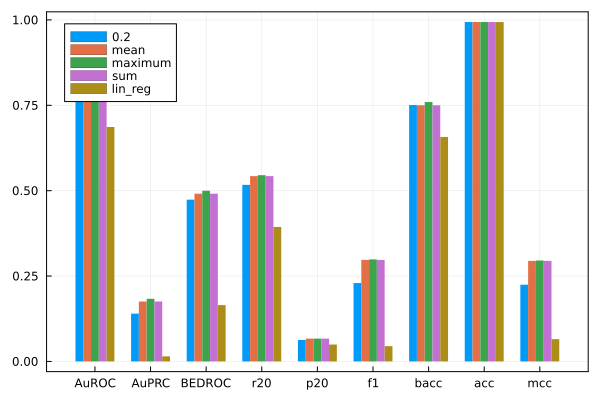

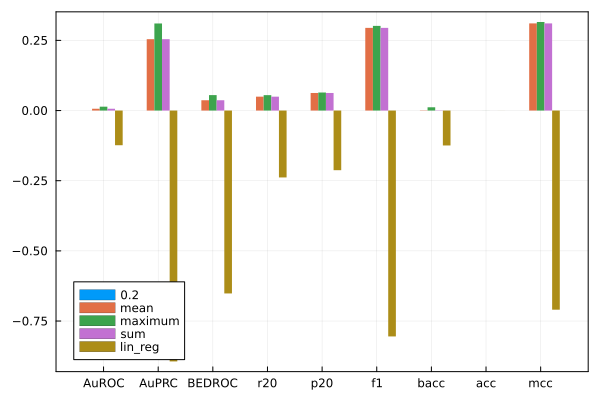

(9×6 DataFrame
 Row │ metric  0.2        mean       maximum    sum        lin_reg   
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?  
─────┼───────────────────────────────────────────────────────────────
   1 │ AuROC   0.783286   0.788326   0.794083   0.788326   0.686515
   2 │ AuPRC   0.13993    0.175512   0.183345   0.175512   0.0148442
   3 │ BEDROC  0.473685   0.491081   0.49976    0.491081   0.164996
   4 │ r20     0.517002   0.542592   0.545372   0.542592   0.39378
   5 │ p20     0.0628364  0.0667702  0.0668737  0.0667702  0.0494824
   6 │ f1      0.229549   0.297174   0.298799   0.297174   0.0447936
   7 │ bacc    0.750781   0.750061   0.759519   0.750061   0.657388
   8 │ acc     0.993846   0.993862   0.993946   0.993862   0.993757
   9 │ mcc     0.224686   0.294465   0.295586   0.294465   0.0652525, 9×6 DataFrame
 Row │ metric  0.2       mean          maximum      sum           lin_reg     
     │ String  Float64?  Float64?      Float64?     Float64?      

In [22]:
@iload LinearRegressor pkg=MLJLinearModels verbosity=0
fxs = [mean, maximum, sum]
norm_metrics(df, df_train, fxs, lin_reg, "0.2", true)

[ Info: Training machine(RandomForestRegressor(max_depth = -1, …), …).


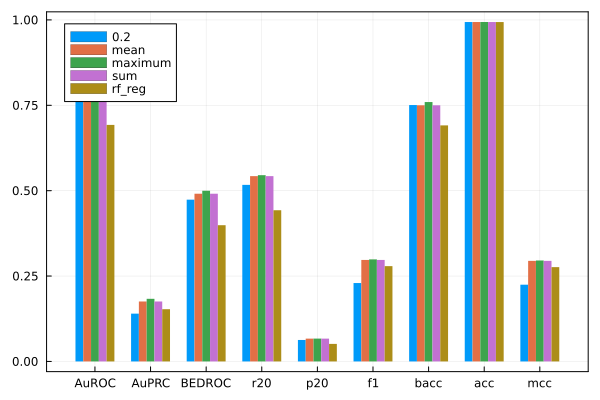

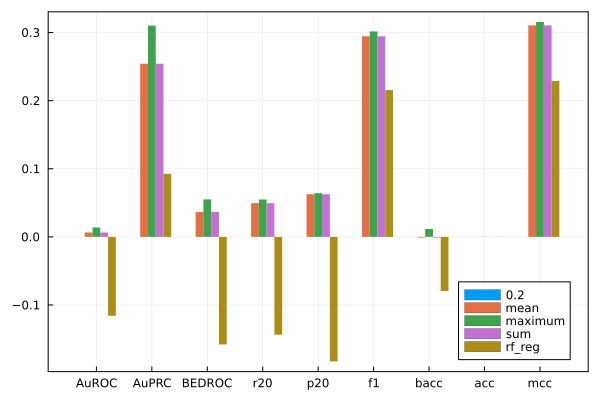

(9×6 DataFrame
 Row │ metric  0.2        mean       maximum    sum        rf_reg    
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?  
─────┼───────────────────────────────────────────────────────────────
   1 │ AuROC   0.783286   0.788326   0.794083   0.788326   0.692612
   2 │ AuPRC   0.13993    0.175512   0.183345   0.175512   0.152904
   3 │ BEDROC  0.473685   0.491081   0.49976    0.491081   0.398895
   4 │ r20     0.517002   0.542592   0.545372   0.542592   0.44272
   5 │ p20     0.0628364  0.0667702  0.0668737  0.0667702  0.0513458
   6 │ f1      0.229549   0.297174   0.298799   0.297174   0.279027
   7 │ bacc    0.750781   0.750061   0.759519   0.750061   0.691193
   8 │ acc     0.993846   0.993862   0.993946   0.993862   0.993752
   9 │ mcc     0.224686   0.294465   0.295586   0.294465   0.276112, 9×6 DataFrame
 Row │ metric  0.2       mean          maximum      sum           rf_reg      
     │ String  Float64?  Float64?      Float64?     Float64?      Flo

In [23]:
@iload RandomForestRegressor pkg=DecisionTree verbosity=0
fxs = [mean, maximum, sum]
norm_metrics(df, df_train, fxs, rf_reg, "0.2", true)

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


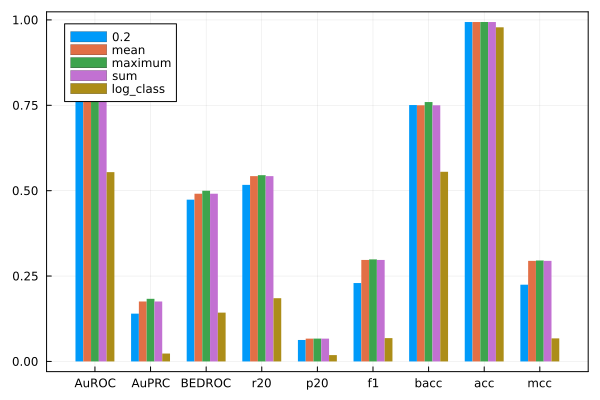

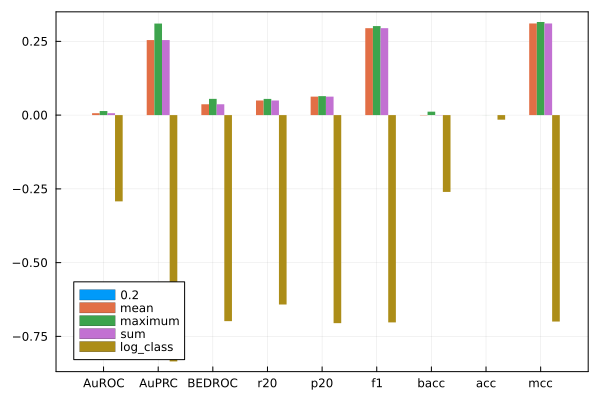

(9×6 DataFrame
 Row │ metric  0.2        mean       maximum    sum        log_class 
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?  
─────┼───────────────────────────────────────────────────────────────
   1 │ AuROC   0.783286   0.788326   0.794083   0.788326   0.554286
   2 │ AuPRC   0.13993    0.175512   0.183345   0.175512   0.0231126
   3 │ BEDROC  0.473685   0.491081   0.49976    0.491081   0.142922
   4 │ r20     0.517002   0.542592   0.545372   0.542592   0.18514
   5 │ p20     0.0628364  0.0667702  0.0668737  0.0667702  0.01853
   6 │ f1      0.229549   0.297174   0.298799   0.297174   0.0682794
   7 │ bacc    0.750781   0.750061   0.759519   0.750061   0.555318
   8 │ acc     0.993846   0.993862   0.993946   0.993862   0.9784
   9 │ mcc     0.224686   0.294465   0.295586   0.294465   0.0674864, 9×6 DataFrame
 Row │ metric  0.2       mean          maximum      sum           log_class  
     │ String  Float64?  Float64?      Float64?     Float64?      Float

In [12]:
@iload LogisticClassifier pkg=MLJLinearModels verbosity=0
fxs = [mean, maximum, sum]
norm_metrics(df, df_train, fxs, log_class, "0.2", false)

[ Info: Training machine(RandomForestClassifier(max_depth = -1, …), …).


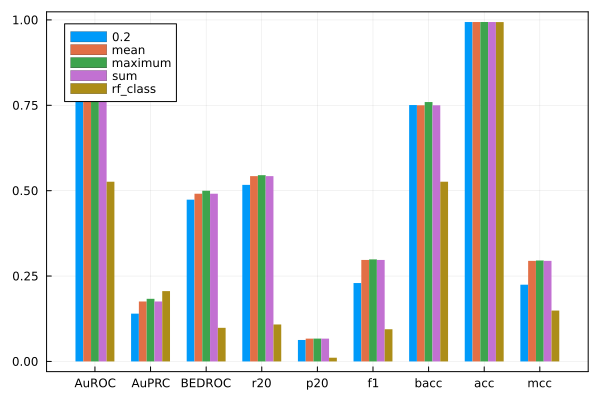

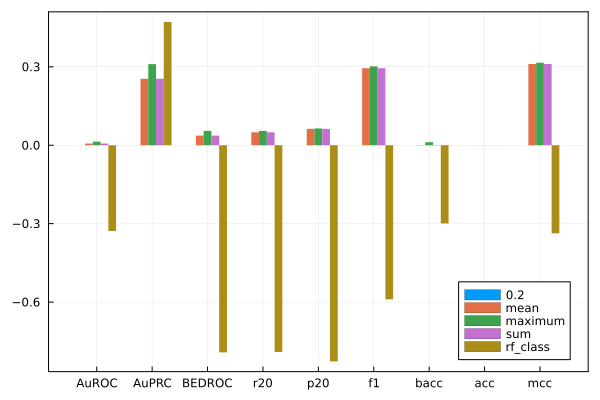

(9×6 DataFrame
 Row │ metric  0.2        mean       maximum    sum        rf_class  
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?  
─────┼───────────────────────────────────────────────────────────────
   1 │ AuROC   0.783286   0.788326   0.794083   0.788326   0.526237
   2 │ AuPRC   0.13993    0.175512   0.183345   0.175512   0.205895
   3 │ BEDROC  0.473685   0.491081   0.49976    0.491081   0.0983931
   4 │ r20     0.517002   0.542592   0.545372   0.542592   0.108221
   5 │ p20     0.0628364  0.0667702  0.0668737  0.0667702  0.0108696
   6 │ f1      0.229549   0.297174   0.298799   0.297174   0.0942408
   7 │ bacc    0.750781   0.750061   0.759519   0.750061   0.526249
   8 │ acc     0.993846   0.993862   0.993946   0.993862   0.993653
   9 │ mcc     0.224686   0.294465   0.295586   0.294465   0.148959, 9×6 DataFrame
 Row │ metric  0.2       mean          maximum      sum           rf_class     ⋯
     │ String  Float64?  Float64?      Float64?     Float64?    

In [16]:
@iload RandomForestClassifier pkg=DecisionTree verbosity=0
fxs = [mean, maximum, sum]
norm_metrics(df, df_train, fxs, rf_class, "0.2", false)

In [11]:
# normalized scores implementation

y, X = prepare_machine(normalize_scores(df))
yt, Xt = prepare_machine(normalize_scores(df_train); rng=123)

# balanced sampling implementation

y, X = machine_input(df)
yt, Xt = prepare_machine(balance_sample(df_train); rng=123)


# balanced sampling with normalized scores

y, X = prepare_machine(normalize_scores(df))
yt, Xt = prepare_machine(balance_normalized(df_train); rng=123)

(CategoricalArrays.CategoricalValue{Float64, UInt32}[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 899496×21 DataFrame
    Row │ 0.0          0.05         0.1          0.15         0.2          0.2 ⋯
        │ Float64      Float64      Float64      Float64      Float64      Flo ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ 0.00367209   0.0040108    0.00602465   0.00815318   0.0080461    0.0 ⋯
      2 │ 0.00283857   0.00174765   0.000120542  0.0          0.0          0.0
      3 │ 0.00129108   0.00141723   0.00180912   0.00052573   0.0          0.0
      4 │ 0.00208259   0.00217538   0.00194966   0.00147136   0.0          0.0
      5 │ 0.00107698   0.00111954   0.000839346  0.00121821   0.0          0.0 ⋯
      6 │ 0.00165377   0.00163625   0.00112017   0.000673262  0.0          0.0
      7 │ 0.00113204   0.00117906   0.00132414   0.00141671   0.0          0.0
      8 │ 0.00211391   

In [19]:


Model = @iload RandomForestClassifier pkg=MLJScikitLearnInterface verbosity=0
p2 = Model(random_state=123)
w = map(x -> if x == 1 x = 250 else 1 end , yt)
m2 = machine(p2, Xt, yt, w) |> fit!
yhat = MLJ.predict_mode(m2, X)
MLJ.confmat(yhat, y)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc MLJScikitLearnInterface.RandomForestClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{AbstractVector{Continuous}}, AbstractVector{Multiclass{2}}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:Union{AbstractVector{<:Count}, AbstractVector{<:Continuous}}}, AbstractVector{<:Finite}}
└ @ MLJBase ~/.julia/packages/MLJBase

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   189574    │    1183     │
├─────────────┼─────────────┼─────────────┤
│     1.0     │     21      │      7      │
└─────────────┴─────────────┴─────────────┘


In [13]:
y, X = prepare_machine(normalize_scores(df))
yt, Xt = prepare_machine(balance_normalized(df_train); rng=123)

Model = @iload LogisticClassifier pkg=MLJLinearModels verbosity=0
p2 = Model()
m1 = machine(p2, Xt, yt) |> fit!
yhat = MLJ.predict(m1, X)
yhat

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


190785-element CategoricalDistributions.UnivariateFiniteVector{Multiclass{2}, Float64, UInt32, Float64}:
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.00026)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.000276)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.000268)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.000274)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.000256)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.000266)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.000269)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.000277)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.000262)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.000274)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.000262)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.000272)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.000259)
 ⋮
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>1.72e-7)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>2.58e-8)
 UnivariateFinite{Multicl

In [30]:
y = coerce(y, Continuous)
yt = coerce(yt, Continuous)
Model = @iload LinearRegressor pkg=MLJLinearModels verbosity=0
p2 = Model()
m1 = machine(p2, Xt, yt) |> fit!
yhat = MLJ.predict(m1, X)


[ Info: Training machine(LinearRegressor(fit_intercept = true, …), …).
┌ Info: Solver: MLJLinearModels.Analytical
│   iterative: Bool false
└   max_inner: Int64 200


190785-element Vector{Float64}:
 1.0684378880370915
 1.068485975765333
 1.0685727975608306
 1.0684736471068779
 1.0687190011477359
 1.0682484720291925
 1.0684348348527373
 1.0687887438227526
 1.0686820497191774
 1.0684602708259736
 1.076050604848928
 1.0685319503046382
 1.0693900336877447
 ⋮
 1.0963366355700457
 1.1024714396198045
 1.0760140410296994
 1.0735517750110144
 1.0759057000916181
 1.0895270076023007
 1.1045645323830355
 1.111566877132237
 1.0725224491627487
 1.079296872316882
 1.0844478438077139
 1.0719536907121676

In [31]:
yhat = MLJ.predict_mode(m1, X)

190785-element Vector{Float64}:
 1.0684378880370915
 1.068485975765333
 1.0685727975608306
 1.0684736471068779
 1.0687190011477359
 1.0682484720291925
 1.0684348348527373
 1.0687887438227526
 1.0686820497191774
 1.0684602708259736
 1.076050604848928
 1.0685319503046382
 1.0693900336877447
 ⋮
 1.0963366355700457
 1.1024714396198045
 1.0760140410296994
 1.0735517750110144
 1.0759057000916181
 1.0895270076023007
 1.1045645323830355
 1.111566877132237
 1.0725224491627487
 1.079296872316882
 1.0844478438077139
 1.0719536907121676

In [12]:
Model = @iload XGBoostClassifier pkg=XGBoost verbosity=0
p2 = Model()
m1 = machine(p2, Xt, yt) |> fit!
yhat = MLJ.predict_mode(m1, X)
MLJ.confmat(yhat, y)

[ Info: Training machine(XGBoostClassifier(test = 1, …), …).
[ Info: XGBoost: starting training.
[ Info: [1]	train-logloss:0.43818339285860586
[ Info: [2]	train-logloss:0.29734261191433997
[ Info: [3]	train-logloss:0.20858089572374883
[ Info: [4]	train-logloss:0.14920535393318879
[ Info: [5]	train-logloss:0.10811742629094459
[ Info: [6]	train-logloss:0.07905532625217435
[ Info: [7]	train-logloss:0.05822719182141640
[ Info: [8]	train-logloss:0.04315015964764220
[ Info: [9]	train-logloss:0.03216746279765709
[ Info: [10]	train-logloss:0.02410907843942929
[ Info: [11]	train-logloss:0.01821361159807343
[ Info: [12]	train-logloss:0.01387474199742497
[ Info: [13]	train-logloss:0.01067085108338377
[ Info: [14]	train-logloss:0.00829682981537283
[ Info: [15]	train-logloss:0.00653110093078212
[ Info: [16]	train-logloss:0.00522600521202952
[ Info: [17]	train-logloss:0.00426726478121633
[ Info: [18]	train-logloss:0.00354527810352828
[ Info: [19]	train-logloss:0.00299314968034354
[ Info: [20]	train-

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   189575    │    1185     │
├─────────────┼─────────────┼─────────────┤
│     1.0     │     20      │      5      │
└─────────────┴─────────────┴─────────────┘


In [71]:

println("number of positives in train set : ",
    size(filter(:TP => n -> n == 1, rescore(df_train[!, :])))[1])
println("total of rows in train set : ",
    size(rescore(df_train))[1])

number of positives in train set : 5009
total of rows in train set : 899496


balance_normalized (generic function with 3 methods)

In [57]:
# multiple sampling

balance_sample(df_train, 3)

Row,Ligando,Target,TP,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
,String15,String15,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,CHEMBL6466,CHEMBL205,1.0,0.0390387,0.0391395,0.0657672,0.204205,0.409901,0.604253,0.719712,0.811333,0.885494,0.907947,0.918306,0.924394,0.94568,0.960476,0.960476,0.960476,0.960476,0.960476,0.96064,0.96064,0.96064
2,CHEMBL2403108,CHEMBL1974,1.0,0.0571783,0.0612339,0.0917495,0.202682,0.460126,0.664453,0.802983,0.765275,0.781335,0.790679,0.795898,0.799965,0.805662,0.807772,0.808231,0.808231,0.808391,0.808489,0.810412,0.810601,0.815432
3,CHEMBL154,CHEMBL4681,1.0,0.00908813,0.00990378,0.0154241,0.0360568,0.0988434,0.269648,0.372449,0.313038,0.344957,0.389627,0.394829,0.568515,0.58127,0.593506,0.593506,0.61467,0.61467,0.61467,0.61467,0.61467,0.61467
4,CHEMBL118,CHEMBL3242,1.0,0.0368952,0.0391412,0.0778735,0.339245,0.607702,0.809711,0.87808,0.844418,0.881825,0.896859,0.90182,0.916421,0.930512,0.935087,0.935087,0.935087,0.935087,0.935087,0.935168,0.935168,0.935168
5,CHEMBL607707,CHEMBL2777,1.0,0.0476183,0.0507963,0.0932785,0.246877,0.386412,0.437971,0.456521,0.465223,0.473254,0.47568,0.473809,0.476353,0.476068,0.4766,0.479236,0.479236,0.480952,0.481284,0.481284,0.482075,0.482075
6,CHEMBL535,CHEMBL5627,1.0,0.0900329,0.0950559,0.173196,0.486579,0.764679,0.854947,0.876031,0.882951,0.888524,0.889882,0.891154,0.892347,0.892347,0.888019,0.888019,0.888019,0.888019,0.888019,0.888019,0.888866,0.888866
7,CHEMBL134,CHEMBL1867,1.0,0.0272206,0.0251288,0.0385739,0.192566,0.440808,0.602042,0.738941,0.633896,0.680153,0.68312,0.686423,0.690781,0.713976,0.722679,0.725205,0.725422,0.725422,0.725422,0.725422,0.726656,0.735202
8,CHEMBL1230609,CHEMBL3717,1.0,0.0234893,0.0254701,0.0438428,0.125463,0.276,0.465364,0.62523,0.600901,0.516065,0.514444,0.531405,0.531563,0.531647,0.450177,0.450234,0.450234,0.450262,0.450262,0.450262,0.450372,0.450432
9,CHEMBL75094,CHEMBL3869,1.0,0.00559016,0.00580098,0.0107172,0.078599,0.457855,0.628333,0.628333,0.628333,0.628333,0.628333,0.628333,0.628333,0.628333,0.628333,0.698148,0.698148,0.698148,0.698148,0.698148,0.698148,0.698148


In [14]:
# balanced sampling implementation

y, X = machine_input(df)
yt, Xt = prepare_machine(balance_sample(df_train); rng=123)

(CategoricalArrays.CategoricalValue{Float64, UInt32}[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0  …  1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], 2000×21 DataFrame
  Row │ 0.0          0.05         0.1          0.15         0.2          0.25  ⋯
      │ Float64      Float64      Float64      Float64      Float64      Float ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 0.00179051   0.00230395   0.0150569    0.159155     0.611111     0.666 ⋯
    2 │ 0.0354725    0.0378991    0.0513219    0.161269     0.343903     0.459
    3 │ 0.0358216    0.0376486    0.0632603    0.163416     0.28963      0.347
    4 │ 0.0851813    0.0900405    0.16607      0.44213      0.620494     0.676
    5 │ 0.000894454  0.000999153  0.00137047   0.000992064  0.0          0.0   ⋯
    6 │ 0.0180251    0.0191437    0.0335866    0.0908623    0.176641     0.230
    7 │ 0.00801671   0.00570296   0.00275522   0.00156987   0.0          0.0
    8 │ 0.000890469  0.0009

In [60]:


Model = @iload RandomForestClassifier pkg=MLJScikitLearnInterface verbosity=0
p2 = Model(random_state=123)

m2 = machine(p2, Xt, yt) |> fit!
yhat = MLJ.predict_mode(m2, X)
MLJ.confmat(yhat, y)

[ Info: Training machine(RandomForestClassifier(n_estimators = 100, …), …).
┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase ~/.julia/packages/MLJBase/WKVEo/src/measures/confusion_matrix.jl:116


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   189567    │    1149     │
├─────────────┼─────────────┼─────────────┤
│     1.0     │     28      │     41      │
└─────────────┴─────────────┴─────────────┘


In [61]:
Model = @iload LogisticClassifier pkg=MLJLinearModels verbosity=0
p2 = Model()
m1 = machine(p2, Xt, yt) |> fit!
yhat = MLJ.predict_mode(m1, X)
MLJ.confmat(yhat, y)

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()
┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase ~/.julia/packages/MLJBase/WKVEo/src/measures/confusion_matrix.jl:116


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   189582    │    1176     │
├─────────────┼─────────────┼─────────────┤
│     1.0     │     13      │     14      │
└─────────────┴─────────────┴─────────────┘


In [15]:
Model = @iload XGBoostClassifier pkg=XGBoost verbosity=0
p2 = Model()
m1 = machine(p2, Xt, yt) |> fit!
yhat = MLJ.predict_mode(m1, X)
MLJ.confmat(yhat, y)

[ Info: Training machine(XGBoostClassifier(test = 1, …), …).
[ Info: XGBoost: starting training.
[ Info: [1]	train-logloss:0.43935536974668504
[ Info: [2]	train-logloss:0.29888201522827146
[ Info: [3]	train-logloss:0.21034282834827900
[ Info: [4]	train-logloss:0.15112075981497763
[ Info: [5]	train-logloss:0.11015782951563596
[ Info: [6]	train-logloss:0.08124167706072330
[ Info: [7]	train-logloss:0.06030543389543891
[ Info: [8]	train-logloss:0.04511333042941987
[ Info: [9]	train-logloss:0.03420602382905781
[ Info: [10]	train-logloss:0.02604121375735849
[ Info: [11]	train-logloss:0.02019124289136380
[ Info: [12]	train-logloss:0.01588336599525064
[ Info: [13]	train-logloss:0.01253014361765236
[ Info: [14]	train-logloss:0.01018238534312695
[ Info: [15]	train-logloss:0.00828733876999468
[ Info: [16]	train-logloss:0.00700103522650897
[ Info: [17]	train-logloss:0.00604052451869938
[ Info: [18]	train-logloss:0.00524653150315862
[ Info: [19]	train-logloss:0.00467439413932152
[ Info: [20]	train-

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   189546    │    1129     │
├─────────────┼─────────────┼─────────────┤
│     1.0     │     49      │     61      │
└─────────────┴─────────────┴─────────────┘


In [16]:
# balanced sampling with normalized scores

y, X = prepare_machine(normalize_scores(df))
yt, Xt = prepare_machine(balance_normalized(df_train); rng=123)

(CategoricalArrays.CategoricalValue{Float64, UInt32}[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0  …  1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], 2000×21 DataFrame
  Row │ 0.0          0.05         0.1          0.15         0.2          0.25  ⋯
      │ Float64      Float64      Float64      Float64      Float64      Float ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 0.0254974    0.0268477    0.0606251    0.227092     0.331738     0.405 ⋯
    2 │ 0.0252457    0.0273613    0.0439146    0.117691     0.293922     0.680
    3 │ 0.0255276    0.0275365    0.0424698    0.11194      0.256911     0.382
    4 │ 0.00710486   0.00763173   0.0139102    0.0634999    0.266289     0.732
    5 │ 0.00178016   0.00120399   0.000512503  0.000457638  0.0          0.0   ⋯
    6 │ 0.0227445    0.0254834    0.0584412    0.185071     0.482184     0.557
    7 │ 0.0011568    0.00122357   0.0012738    0.00115268   0.0          0.0
    8 │ 0.00579333   0.0058

In [63]:


Model = @iload RandomForestClassifier pkg=MLJScikitLearnInterface verbosity=0
p2 = Model(random_state=123)

m2 = machine(p2, Xt, yt) |> fit!
yhat = MLJ.predict_mode(m2, X)
MLJ.confmat(yhat, y)

[ Info: Training machine(RandomForestClassifier(n_estimators = 100, …), …).
┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase ~/.julia/packages/MLJBase/WKVEo/src/measures/confusion_matrix.jl:116


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   189506    │    1125     │
├─────────────┼─────────────┼─────────────┤
│     1.0     │     89      │     65      │
└─────────────┴─────────────┴─────────────┘


In [21]:
Model = @iload LogisticClassifier pkg=MLJLinearModels verbosity=0
p2 = Model()
m1 = machine(p2, Xt, yt) |> fit!
yhat = MLJ.predict_mode(m1, X)
MLJ.confmat(yhat, y)

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()
┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase ~/.julia/packages/MLJBase/WKVEo/src/measures/confusion_matrix.jl:116


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   184992    │     832     │
├─────────────┼─────────────┼─────────────┤
│     1.0     │    4603     │     358     │
└─────────────┴─────────────┴─────────────┘


In [22]:
MLJ.mcc(yhat, y)

0.1368183459442398

In [17]:
Model = @iload XGBoostClassifier pkg=XGBoost verbosity=0
p2 = Model()
m1 = machine(p2, Xt, yt) |> fit!
yhat = MLJ.predict_mode(m1, X)
MLJ.confmat(yhat, y)

[ Info: Training machine(XGBoostClassifier(test = 1, …), …).
[ Info: XGBoost: starting training.
[ Info: [1]	train-logloss:0.44053932540118695
[ Info: [2]	train-logloss:0.30057047398388387
[ Info: [3]	train-logloss:0.21194250636547804
[ Info: [4]	train-logloss:0.15279602577537299
[ Info: [5]	train-logloss:0.11158488365262746
[ Info: [6]	train-logloss:0.08242941327765584
[ Info: [7]	train-logloss:0.06141752715222538
[ Info: [8]	train-logloss:0.04612990135326982
[ Info: [9]	train-logloss:0.03488204776681959
[ Info: [10]	train-logloss:0.02652512996364385
[ Info: [11]	train-logloss:0.02040533187426627
[ Info: [12]	train-logloss:0.01590025488659740
[ Info: [13]	train-logloss:0.01264430108526722
[ Info: [14]	train-logloss:0.01015909901331179
[ Info: [15]	train-logloss:0.00831019638292491
[ Info: [16]	train-logloss:0.00693182369810529
[ Info: [17]	train-logloss:0.00585339442244731
[ Info: [18]	train-logloss:0.00504953938943800
[ Info: [19]	train-logloss:0.00443455069488846
[ Info: [20]	train-

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   189550    │    1161     │
├─────────────┼─────────────┼─────────────┤
│     1.0     │     45      │     29      │
└─────────────┴─────────────┴─────────────┘


In [27]:
# balanced oversampling with normalized scores

y, X = prepare_machine(normalize_scores(df))
yt, Xt = prepare_machine(balance_normalized(df_train, 2); rng=123)

(CategoricalArrays.CategoricalValue{Float64, UInt32}[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], 1500×21 DataFrame
  Row │ 0.0          0.05         0.1          0.15         0.2         0.25   ⋯
      │ Float64      Float64      Float64      Float64      Float64     Float6 ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 0.00864885   0.00926546   0.016444     0.0659749    0.305844    0.5141 ⋯
    2 │ 0.0409928    0.0440315    0.0432754    0.0973983    0.421678    0.6605
    3 │ 0.0438064    0.0466377    0.0852456    0.228828     0.367113    0.4219
    4 │ 0.039011     0.0411801    0.0759458    0.206918     0.298102    0.3225
    5 │ 0.0158479    0.0170987    0.0325309    0.135708     0.491818    0.8647 ⋯
    6 │ 0.0394868    0.0417192    0.0743222    0.209063     0.345837    0.4190
    7 │ 0.033575     0.0372139    0.0877538    0.234321     0.442697    0.6386
    8 │ 0.0278747    0.02

In [29]:

Model = @iload RandomForestClassifier pkg=MLJScikitLearnInterface verbosity=0
p2 = Model(random_state=123)

m2 = machine(p2, Xt, yt) |> fit!
yhat = MLJ.predict_mode(m2, X)
MLJ.confmat(yhat, y)

[ Info: Training machine(RandomForestClassifier(n_estimators = 100, …), …).
┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase ~/.julia/packages/MLJBase/WKVEo/src/measures/confusion_matrix.jl:116


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   189546    │    1161     │
├─────────────┼─────────────┼─────────────┤
│     1.0     │     49      │     29      │
└─────────────┴─────────────┴─────────────┘


In [28]:
Model = @iload LogisticClassifier pkg=MLJLinearModels verbosity=0
p2 = Model()
m1 = machine(p2, Xt, yt) |> fit!
yhat = MLJ.predict_mode(m1, X)
MLJ.confmat(yhat, y)

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()
┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase ~/.julia/packages/MLJBase/WKVEo/src/measures/confusion_matrix.jl:116


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   184511    │     959     │
├─────────────┼─────────────┼─────────────┤
│     1.0     │    5084     │     231     │
└─────────────┴─────────────┴─────────────┘


In [31]:
# balanced sampling with normalized scores
# random forest with overweighted class

y, X = prepare_machine(normalize_scores(df))
yt, Xt = prepare_machine(balance_normalized(df_train); rng=123)

Model = @iload RandomForestClassifier pkg=MLJScikitLearnInterface verbosity=0
p2 = Model(random_state=123)
w = map(x -> if x == 1 x = 180 else 1 end , yt)
m1 = machine(p2, Xt, yt, w) |> fit!
yhat = MLJ.predict_mode(m1, X)
MLJ.confmat(yhat, y)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc MLJScikitLearnInterface.RandomForestClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{AbstractVector{Continuous}}, AbstractVector{Multiclass{2}}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:Union{AbstractVector{<:Count}, AbstractVector{<:Continuous}}}, AbstractVector{<:Finite}}
└ @ MLJBase ~/.julia/packages/MLJBase

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   189529    │    1137     │
├─────────────┼─────────────┼─────────────┤
│     1.0     │     66      │     53      │
└─────────────┴─────────────┴─────────────┘


In [35]:
""" PERFECT CLASSIFICATION TEST """

yt, Xt =  machine_input_testm(df_train; rng=123)

Model = @iload RandomForestClassifier pkg=MLJScikitLearnInterface verbosity=0
p2 = Model(random_state=123)
w = map(x -> if x == 1 x = 180 else 1 end , yt)
m1 = machine(p2, Xt, yt, w) |> fit!

y, X =  machine_input_testm(df)
yhat = MLJ.predict_mode(m1, X)
MLJ.confmat(yhat, y)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc MLJScikitLearnInterface.RandomForestClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{Union{AbstractVector{Continuous}, AbstractVector{OrderedFactor{2}}}}, AbstractVector{Multiclass{2}}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:Union{AbstractVector{<:Count}, AbstractVector{<:Continuous}}}, AbstractVector{<:Finit

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   189595    │      0      │
├─────────────┼─────────────┼─────────────┤
│     1.0     │      0      │    1190     │
└─────────────┴─────────────┴─────────────┘


In [36]:
fitted_params(m1)[7]

Python ndarray:
array([0.00318358, 0.00355661, 0.00246742, 0.00290697, 0.00166913,
       0.00856747, 0.00108865, 0.00873076, 0.00899302, 0.00073677,
       0.00132381, 0.02581929, 0.03460766, 0.04155939, 0.06678025,
       0.05214366, 0.06194802, 0.10179483, 0.07909144, 0.13601792,
       0.07986897, 0.27714437])

In [37]:
fitted_params(m1)

(estimator = <py DecisionTreeClassifier()>,
 estimators = <py [DecisionTreeClassifier(max_features='sqrt', random_state=843828734), DecisionTreeClassifier(max_features='sqrt', random_state=914636141), DecisionTreeClassifier(max_features='sqrt', random_state=1228959102), DecisionTreeClassifier(max_features='sqrt', random_state=1840268610), DecisionTreeClassifier(max_features='sqrt', random_state=974319580), DecisionTreeClassifier(max_features='sqrt', random_state=819844194), DecisionTreeClassifier(max_features='sqrt', random_state=220395238), DecisionTreeClassifier(max_features='sqrt', random_state=941243409), DecisionTreeClassifier(max_features='sqrt', random_state=942612051), DecisionTreeClassifier(max_features='sqrt', random_state=2109339754), DecisionTreeClassifier(max_features='sqrt', random_state=1817228411), DecisionTreeClassifier(max_features='sqrt', random_state=1202710073), DecisionTreeClassifier(max_features='sqrt', random_state=2064866518), DecisionTreeClassifier(max_feature

In [48]:
fitted_params(m1)[2]

Python list: [DecisionTreeClassifier(max_features='sqrt', random_state=843828734), DecisionTreeClassifier(max_features='sqrt', random_state=914636141), DecisionTreeClassifier(max_features='sqrt', random_state=1228959102), DecisionTreeClassifier(max_features='sqrt', random_state=1840268610), DecisionTreeClassifier(max_features='sqrt', random_state=974319580), DecisionTreeClassifier(max_features='sqrt', random_state=819844194), DecisionTreeClassifier(max_features='sqrt', random_state=220395238), DecisionTreeClassifier(max_features='sqrt', random_state=941243409), DecisionTreeClassifier(max_features='sqrt', random_state=942612051), DecisionTreeClassifier(max_features='sqrt', random_state=2109339754), DecisionTreeClassifier(max_features='sqrt', random_state=1817228411), DecisionTreeClassifier(max_features='sqrt', random_state=1202710073), DecisionTreeClassifier(max_features='sqrt', random_state=2064866518), DecisionTreeClassifier(max_features='sqrt', random_state=1764906721), DecisionTreeC

In [21]:

yt, Xt =  machine_input(df_train; rng=123)

Model = @iload RandomForestClassifier pkg=MLJScikitLearnInterface verbosity=0
p2 = Model(random_state=123)
w = map(x -> if x == 1 x = 250 else 1 end , yt)
m2 = machine(p2, Xt, yt, w) |> fit!

y, X =  machine_input(df)
yhat = MLJ.predict_mode(m2, X)
MLJ.confmat(yhat, y)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc MLJScikitLearnInterface.RandomForestClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{AbstractVector{Continuous}}, AbstractVector{Multiclass{2}}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:Union{AbstractVector{<:Count}, AbstractVector{<:Continuous}}}, AbstractVector{<:Finite}}
└ @ MLJBase ~/.julia/packages/MLJBase

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   189591    │    1186     │
├─────────────┼─────────────┼─────────────┤
│     1.0     │      4      │      4      │
└─────────────┴─────────────┴─────────────┘


In [31]:

fitted_params(m2)[7]

Python ndarray:
array([0.01303042, 0.01318058, 0.01054314, 0.01394132, 0.00890395,
       0.01530471, 0.00682443, 0.00645213, 0.02203559, 0.0145412 ,
       0.0223325 , 0.02241424, 0.04626918, 0.04722426, 0.04725196,
       0.15365495, 0.06644528, 0.08382295, 0.10681723, 0.17601771,
       0.10299226])

In [34]:
rescore(df)

Row,Ligando,Target,TP,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
,String15,String15,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,CHEMBL1062,CHEMBL1075132,0.0,2.27353e-5,2.49703e-5,5.02698e-5,9.6681e-7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CHEMBL1062,CHEMBL1075145,0.0,5.10256e-6,5.72355e-6,1.55182e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CHEMBL1062,CHEMBL1075165,0.0,2.16946e-5,2.20103e-5,8.6793e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CHEMBL1062,CHEMBL1075323,0.0,9.05151e-6,9.3893e-6,6.63393e-6,9.6681e-7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,CHEMBL1062,CHEMBL1163125,0.0,4.21232e-5,4.35057e-5,2.71583e-5,9.91379e-7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,CHEMBL1062,CHEMBL1250378,0.0,6.50849e-6,8.62989e-6,5.37322e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,CHEMBL1062,CHEMBL1293224,0.0,1.6584e-5,1.61176e-5,1.38519e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,CHEMBL1062,CHEMBL1293226,0.0,2.15297e-5,2.25363e-5,2.6445e-5,5.93017e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,CHEMBL1062,CHEMBL1293267,0.0,2.88745e-5,3.11141e-5,2.22767e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
counter(w)

Accumulator{Int64, Int64} with 2 entries:
  180 => 894487
  1   => 5009

In [137]:
counter(yt)

Accumulator{CategoricalArrays.CategoricalValue{Float64, UInt32}, Int64} with 2 entries:
  0.0 => 894487
  1.0 => 5009

In [135]:
Xt

Row,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.00351908,0.00384369,0.00577362,0.00781346,0.00771084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00317613,0.00195548,0.000134877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000892863,0.000980101,0.00125112,0.000363575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000892863,0.000932642,0.000835872,0.000630813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000891269,0.000926487,0.000694612,0.00100814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000892063,0.000882609,0.00060423,0.000363165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000890469,0.000927459,0.00104158,0.00111439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.00179051,0.00192508,0.00268499,0.00458636,0.00480769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.00614734,0.00673375,0.0108858,0.0116719,0.00438636,0.00221729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
yt, Xt =  machine_input(df_train; rng=123)

Model = @iload RandomForestClassifier pkg=MLJScikitLearnInterface verbosity=0
p2 = Model()
# w = map(x -> if x == 0 x = 180 else 1 end , yt)
m1 = machine(p2, Xt, yt) |> fit!

y, X =  machine_input(df)
yhat = MLJ.predict_mode(m1, X)
MLJ.confmat(yhat, y)

[ Info: Training machine(RandomForestClassifier(n_estimators = 100, …), …).
┌ Error: Problem fitting the machine machine(RandomForestClassifier(n_estimators = 100, …), …). 
└ @ MLJBase ~/.julia/packages/MLJBase/WKVEo/src/machines.jl:682
[ Info: Running type checks... 
[ Info: Type checks okay. 


LoadError: InterruptException:

In [ ]:
Xt

In [122]:
w = map(x -> if x == 0 x = 180 else 1 end , yt)
counter(yt)

Accumulator{CategoricalArrays.CategoricalValue{Float64, UInt32}, Int64} with 2 entries:
  0.0 => 894487
  1.0 => 5009

In [124]:
counter(w)

Accumulator{Int64, Int64} with 2 entries:
  160 => 894487
  1   => 5009

In [93]:
MLJ.mcc(yhat, y)

0.20640061593053402

In [98]:
y, yhat, _ = machine_train_predict_testm(df, df_train, log_class)
MLJ.confmat(yhat, y)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc MLJLinearModels.LogisticClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{Union{AbstractVector{Continuous}, AbstractVector{OrderedFactor{2}}}}, AbstractVector{Multiclass{2}}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:AbstractVector{<:Continuous}}, AbstractVector{<:Finite}}
└ @ MLJBase ~/.julia/packages/MLJBase/WKVEo/src/machines.jl:230

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   189595    │      0      │
├─────────────┼─────────────┼─────────────┤
│     1.0     │      0      │    1190     │
└─────────────┴─────────────┴─────────────┘


In [97]:
MLJ.mcc(yhat, y)

1.0

In [101]:
 
yt, Xt =  machine_input_testm(df_train; rng=123)

Model = @iload LogisticClassifier pkg=MLJLinearModels verbosity=0
p2 = Model()
m1 = machine(p2, Xt, yt) |> fit!


┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc MLJLinearModels.LogisticClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{Union{AbstractVector{Continuous}, AbstractVector{OrderedFactor{2}}}}, AbstractVector{Multiclass{2}}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:AbstractVector{<:Continuous}}, AbstractVector{<:Finite}}
└ @ MLJBase ~/.julia/packages/MLJBase/WKVEo/src/machines.jl:230

trained Machine; caches model-specific representations of data
  model: LogisticClassifier(lambda = 2.220446049250313e-16, …)
  args: 
    1:	Source @270 ⏎ Table{Union{AbstractVector{Continuous}, AbstractVector{OrderedFactor{2}}}}
    2:	Source @488 ⏎ AbstractVector{Multiclass{2}}


In [103]:
yt, Xt =  machine_input_testm(df_train; rng=123)

Model = @iload LogisticClassifier pkg=MLJLinearModels verbosity=0
p2 = Model()
m1 = machine(p2, Xt, yt) |> fit!

y, X =  machine_input_testm(df)
yhat = MLJ.predict_mode(m1, X)
MLJ.confmat(yhat, y)

┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase ~/.julia/packages/MLJBase/WKVEo/src/measures/confusion_matrix.jl:116


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   189595    │      0      │
├─────────────┼─────────────┼─────────────┤
│     1.0     │      0      │    1190     │
└─────────────┴─────────────┴─────────────┘


In [107]:
189595/1190

159.3235294117647

In [104]:
fitted_params(m1)[2]

22-element Vector{Pair{Symbol, Float64}}:
  Symbol("0.0") => 1.1706641795205888
 Symbol("0.05") => 1.2694930372613689
  Symbol("0.1") => 2.2316260030703443
 Symbol("0.15") => 7.612491667953766
  Symbol("0.2") => 8.100977718978232
 Symbol("0.25") => -0.7274971359130724
  Symbol("0.3") => -3.926101753496178
 Symbol("0.35") => -4.222981101082843
  Symbol("0.4") => 4.188119847921627
 Symbol("0.45") => 2.5736655565760076
  Symbol("0.5") => 2.219171651329271
 Symbol("0.55") => 1.0481862758588836
  Symbol("0.6") => 0.5790230586598062
 Symbol("0.65") => 0.9029420199971154
  Symbol("0.7") => 0.9166534295529197
 Symbol("0.75") => 0.3123156182994735
  Symbol("0.8") => -0.11933153325402143
 Symbol("0.85") => -0.0616955582629517
  Symbol("0.9") => -0.6590327408580327
 Symbol("0.95") => -0.814891941954687
  Symbol("1.0") => -1.3346059436385804
        :tptest => 57.123497177159464

In [5]:
schema(df)

┌─────────┬────────────┬──────────┐
│ names   │ scitypes   │ types    │
├─────────┼────────────┼──────────┤
│ Fold    │ Count      │ Int64    │
│ Ligando │ Textual    │ String15 │
│ Target  │ Textual    │ String15 │
│ Score   │ Continuous │ Float64  │
│ TP      │ Continuous │ Float64  │
│ Alpha   │ Continuous │ Float64  │
└─────────┴────────────┴──────────┘


In [57]:
function prepare_data(df::DataFrame; args...)
    df = @chain df begin
    select(:Score, :Alpha, :TP)
    end
    df[!, :TP] = convert.(Int64, df[!, :TP])
    df[!, :TP] = categorical(df[!, :TP]; ordered=true)
    y, X = unpack(df, ==(:TP); args...)
    return y, X
end

function prepare_sets(df::DataFrame, df_train::DataFrame)
    y, X = prepare_data(df)
    yt, Xt = prepare_data(df_train; rng=123)
    return y, X, yt, Xt
end

function train_predict(df::DataFrame, df_train::DataFrame, fx; args...)
    # instantiate
    Model = fx
    model = Model()
    # prepare and split sets
    y, X, yt, Xt = prepare_sets(df, df_train)
    # fit machine
    m1 = machine(model(;args...), Xt, yt) |> fit!
    # make predictions 
    yhat = MLJ.predict_mode(m1, X)
    return y, yhat
end

function evaluate_predictions(df::DataFrame, df_train::DataFrame, fx; args...)
    y, yhat = train_predict(df, df_train, fx; args...)
    conf_mat = confmat(yhat, y)
    mcc = MLJ.mcc(yhat, y)
    f1 = MLJ.f1score(yhat, y)
    return conf_mat, mcc, f1
end

    
# format dataframes to match standard format.
function prepare_dataframe(df::DataFrame, yhat)
    df[!, "yhat"] = yhat
    df = @chain df begin
        select([:Ligando, :Target, :Score, :yhat, :TP, :Alpha])
        groupby([:Ligando, :Target, :yhat, :TP, :Alpha])    
        combine(:Score => sum => :Score)
        unstack(:Alpha, :Score)
    end
#     remove both spaces
    df[!, :Target] = strip.(df[!, :Target])
    return df
end    
     

function linear_transform(df::DataFrame, fxs::Vector{Function}, benchmark::String="0.2")
    symbs = []
    tcols = ncol(df)
    
    for f in fxs
        push!(symbs, String(Symbol(f)))
    end
    
    df = @chain df begin
            DataFrames.transform(AsTable(5:tcols) .=> ByRow.(fxs) .=> symbs)
            select(1:4, [benchmark], symbs)
        end
    return df
end


function test_model(df::DataFrame, df_train::DataFrame, fxs, fx, benchmark="0.2"; args...)
    _, yhat = train_predict(df, df_train, fx; args...)
    df = prepare_dataframe(df, yhat)
    df = linear_transform(df, fxs, benchmark)
    return df
end
    
function evaluate_model(df::DataFrame)
    df_f = DataFrame()

    symbs = []
    for name in names(df[!, 4:end])
        push!(symbs, name)
    end
    
    for metric in symbs
        df_t = @chain df begin
            select(["Ligando", "Target", "TP" , metric])
            rename!(4 => :Score)
        end
        
        df_m = getperformance(df_t)
        df_m.groupid = replace(df_m.groupid, missing => metric)
        append!(df_f, df_m)
    end
    
    return df_f
end


function plot_evaluation(df::DataFrame, benchmark::String="0.2")
    gr()
        
    df_plot = @chain df begin
        stack(names(df[:, 2:end]), :groupid)
        unstack(:groupid, :value)
        rename!(:variable => :metric)
    end
    
    df_perct = copy(df_plot)
    for n in 2:ncol(df_perct)
    df_perct[:, n] .= (df_plot[:, n] .- df_plot[:,benchmark]) ./ df_plot[:,benchmark]
    end
    
    plot1 = @df df_plot groupedbar(
    :metric,
    cols(2:ncol(df_plot)),
    bar_width=0.7,
    framestyle = :box,
    lw = 0,
    guidefontsize = 8,
    )
    
    plot2 = @df df_perct groupedbar(
    :metric,
    cols(2:ncol(df_plot)),
    bar_width=0.7,
    framestyle = :box,
    lw = 0,
    guidefontsize = 8,
    )
    
    return plot1, plot2, df_plot, df_perct
end;

        

In [58]:
function show_model_performance(df::DataFrame, df_train::DataFrame, fxs, fx, benchmark="0.2"; args...)
    df1 = test_model(df, df_train, fxs, fx, benchmark; args...)
    df2 = evaluate_model(df)
    plot1, plot2, df_plot, df_perct = plot_evaluation(df2)
    display(plot1)
    display(plot2)
    return df_plot, df_perct
end

show_model_performance (generic function with 2 methods)

In [60]:
df1 = test_model(df, df_train, fxs, log_class)

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


Row,Ligando,Target,TP,yhat,0.2,mean,maximum,sum
,String15,String15,Float64,Cat…,Float64?,Float64?,Float64?,Float64?
1,CHEMBL1062,CHEMBL1075132,0.0,0,0.0,4.71153e-6,5.02698e-5,9.89422e-5
2,CHEMBL1062,CHEMBL1075145,0.0,0,0.0,5.89425e-7,5.72355e-6,1.23779e-5
3,CHEMBL1062,CHEMBL1075165,0.0,0,0.0,2.49448e-6,2.20103e-5,5.23842e-5
4,CHEMBL1062,CHEMBL1075323,0.0,0,0.0,1.24007e-6,9.3893e-6,2.60415e-5
5,CHEMBL1062,CHEMBL1163125,0.0,0,0.0,5.41803e-6,4.35057e-5,0.000113779
6,CHEMBL1062,CHEMBL1250378,0.0,0,0.0,3.27955e-6,5.37322e-5,6.88706e-5
7,CHEMBL1062,CHEMBL1293224,0.0,0,0.0,2.21683e-6,1.6584e-5,4.65534e-5
8,CHEMBL1062,CHEMBL1293226,0.0,0,0.0,6.18155e-6,5.93017e-5,0.000129813
9,CHEMBL1062,CHEMBL1293267,0.0,0,0.0,3.9174e-6,3.11141e-5,8.22653e-5


In [106]:
y, yhat = train_predict(df, df_train, log_class)
MLJ.confmat(yhat, y)

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      0      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │   3981389   │    24827    │
├─────────────┼─────────────┼─────────────┤
│      1      │     106     │     163     │
└─────────────┴─────────────┴─────────────┘


In [59]:
@iload LogisticClassifier pkg=MLJLinearModels verbosity=0
fxs = [mean, maximum, sum]
show_model_performance(df, df_train, fxs, log_class)

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


LoadError: DomainError with -7.638994664296382e18:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

In [29]:
@iload LogisticClassifier pkg=MLJLinearModels verbosity=0
fxs = [mean, maximum, sum]
# evaluate log regression with 
testingdf = test_model(df, df_train, fxs, log_class)

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


LoadError: UndefVarError: y_hat not defined

In [94]:
@iload LogisticClassifier pkg=MLJLinearModels verbosity=0
conf_mat, mcc, f1 = evaluate_predictions(df, df_train, log_class)
mcc
# rf f1 was 0.00667779632721202

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


0.06241772952645642

In [26]:
0.012906290827031949 / 0.00667779632721202 * 100

193.27170513480343

In [61]:
y, yhat = train_predict(df, df_train, log_class)

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


(CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [85]:
MLJ.f1score(yhat, y)

0.012906290827031949

In [73]:
y1, yhat1 = machine_train_predict(df, df_train, log_class)

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


(CategoricalArrays.CategoricalValue{Float64, UInt32}[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], CategoricalArrays.CategoricalValue{Float64, UInt32}[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], nothing)

In [84]:
MLJ.f1score(yhat1, y1)

┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase ~/.julia/packages/MLJBase/WKVEo/src/measures/confusion_matrix.jl:116


0.006666666666666667

In [17]:
scitype(y)

AbstractVector{OrderedFactor{2}} (alias for AbstractArray{OrderedFactor{2}, 1})

In [7]:
@iload RandomForestClassifier pkg=DecisionTree verbosity=0
rf_conf_mat, rf_mcc, rf_f1 = evaluate_predictions(df, df_train, rf_class)
rf_mcc

[ Info: Training machine(RandomForestClassifier(max_depth = -1, …), …).
┌ Error: Problem fitting the machine machine(RandomForestClassifier(max_depth = -1, …), …). 
└ @ MLJBase ~/.julia/packages/MLJBase/WKVEo/src/machines.jl:682
[ Info: Running type checks... 
[ Info: Type checks okay. 


LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90m[4mboot.jl:459[24m[39m[90m [inlined][39m
      [2] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90m[4mboot.jl:468[24m[39m[90m [inlined][39m
      [3] [0m[1msimilar[22m
    [90m    @ [39m[90m./[39m[90m[4marray.jl:378[24m[39m[90m [inlined][39m
      [4] [0m[1msimilar[22m
    [90m    @ [39m[90m./[39m[90m[4mabstractarray.jl:795[24m[39m[90m [inlined][39m
      [5] [0m[1mgetindex[22m
    [90m    @ [39m[90m./[39m[90m[4marray.jl:932[24m[39m[90m [inlined][39m
      [6] [0m[1m_split![22m[0m[1m([22m[90mX[39m::[0mMatrix[90m{Float64}[39m, [90mY[39m::[0mVector[90m{Int64}[39m, [90mW[39m::[0mVector[90m{Int64}[39m, [90mpurity_function[39m::[0mDecisionTree.var"#36#39"[90m{Vector{Float64}}[39m, [90mnode[39m::[0mDecisionTree.treeclassifier.NodeMeta[90m{Float64}[39m, [90mmax_features[39m::[0mInt64, [90mmax_depth[39m::[0mInt64, [90mmin_samples_leaf[39m::[0mInt64, [90mmin_samples_split[39m::[0mInt64, [90mmin_purity_increase[39m::[0mFloat64, [90mindX[39m::[0mVector[90m{Int64}[39m, [90mnc[39m::[0mVector[90m{Int64}[39m, [90mncl[39m::[0mVector[90m{Int64}[39m, [90mncr[39m::[0mVector[90m{Int64}[39m, [90mXf[39m::[0mVector[90m{Float64}[39m, [90mYf[39m::[0mVector[90m{Int64}[39m, [90mWf[39m::[0mVector[90m{Int64}[39m, [90mrng[39m::[0mRandom.Xoshiro[0m[1m)[22m
    [90m    @ [39m[35mDecisionTree.treeclassifier[39m [90m~/.julia/packages/DecisionTree/HRuMd/src/classification/[39m[90m[4mtree.jl:217[24m[39m
      [7] [0m[1m_fit[22m[0m[1m([22m[90mX[39m::[0mMatrix[90m{Float64}[39m, [90mY[39m::[0mVector[90m{Int64}[39m, [90mW[39m::[0mVector[90m{Int64}[39m, [90mloss[39m::[0mFunction, [90mn_classes[39m::[0mInt64, [90mmax_features[39m::[0mInt64, [90mmax_depth[39m::[0mInt64, [90mmin_samples_leaf[39m::[0mInt64, [90mmin_samples_split[39m::[0mInt64, [90mmin_purity_increase[39m::[0mFloat64, [90mrng[39m::[0mRandom.Xoshiro[0m[1m)[22m
    [90m    @ [39m[35mDecisionTree.treeclassifier[39m [90m~/.julia/packages/DecisionTree/HRuMd/src/classification/[39m[90m[4mtree.jl:259[24m[39m
      [8] [0m[1mfit[22m[0m[1m([22m; [90mX[39m::[0mMatrix[90m{Float64}[39m, [90mY[39m::[0mVector[90m{UInt32}[39m, [90mW[39m::[0mNothing, [90mloss[39m::[0mFunction, [90mmax_features[39m::[0mInt64, [90mmax_depth[39m::[0mInt64, [90mmin_samples_leaf[39m::[0mInt64, [90mmin_samples_split[39m::[0mInt64, [90mmin_purity_increase[39m::[0mFloat64, [90mrng[39m::[0mRandom.Xoshiro[0m[1m)[22m
    [90m    @ [39m[35mDecisionTree.treeclassifier[39m [90m~/.julia/packages/DecisionTree/HRuMd/src/classification/[39m[90m[4mtree.jl:306[24m[39m
      [9] [0m[1m#build_tree#30[22m
    [90m    @ [39m[90m~/.julia/packages/DecisionTree/HRuMd/src/classification/[39m[90m[4mmain.jl:156[24m[39m[90m [inlined][39m
     [10] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m~/.julia/packages/DecisionTree/HRuMd/src/classification/[39m[90m[4mmain.jl:491[24m[39m[90m [inlined][39m
     [11] [0m[1m(::DecisionTree.var"#87#threadsfor_fun#40"{DecisionTree.var"#87#threadsfor_fun#37#41"{Random._GLOBAL_RNG, Bool, SubArray{UInt32, 1, Vector{UInt32}, Tuple{Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float64, 2, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}}, true}, Int64, Int64, Int64, Float64, UInt64, DecisionTree.var"#36#39"{Vector{Float64}}, Vector{DecisionTree.Root{Float64, UInt32}}, Int64, Int64, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[35mDecisionTree[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m
     [12] [0m[1m#87#threadsfor_fun[22m
    [90m    @ [39m[90m./[39m[90m[4mthreadingconstructs.jl:51[24m[39m[90m [inlined][39m
     [13] [0m[1m(::Base.Threads.var"#1#2"{DecisionTree.var"#87#threadsfor_fun#40"{DecisionTree.var"#87#threadsfor_fun#37#41"{Random._GLOBAL_RNG, Bool, SubArray{UInt32, 1, Vector{UInt32}, Tuple{Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Float64, 2, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}}, true}, Int64, Int64, Int64, Float64, UInt64, DecisionTree.var"#36#39"{Vector{Float64}}, Vector{DecisionTree.Root{Float64, UInt32}}, Int64, Int64, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:30[24m[39m

In [27]:
@iload XGBoostClassifier pkg=XGBoost verbosity=0
xgb_conf_mat, xgb_mcc, xgb_f1 = evaluate_predictions(df, df_train, xgb_class)
xgb_mcc

[ Info: Training machine(XGBoostClassifier(test = 1, …), …).
[ Info: XGBoost: starting training.
[ Info: [1]	train-logloss:0.43930744127046578
[ Info: [2]	train-logloss:0.29915160504906368
[ Info: [3]	train-logloss:0.21084588804587356
[ Info: [4]	train-logloss:0.15177019904044431
[ Info: [5]	train-logloss:0.11089622883285154
[ Info: [6]	train-logloss:0.08206556157219815
[ Info: [7]	train-logloss:0.06144652556801326
[ Info: [8]	train-logloss:0.04655380888148770
[ Info: [9]	train-logloss:0.03573474263257488
[ Info: [10]	train-logloss:0.02784641923835569
[ Info: [11]	train-logloss:0.02207666744920172
[ Info: [12]	train-logloss:0.01784777952359988
[ Info: [13]	train-logloss:0.01474394367988646
[ Info: [14]	train-logloss:0.01246062078862748
[ Info: [15]	train-logloss:0.01077914602612098
[ Info: [16]	train-logloss:0.00954439719250402
[ Info: [17]	train-logloss:0.00863404595653791
[ Info: [18]	train-logloss:0.00796685065509661
[ Info: [19]	train-logloss:0.00747062871180322
[ Info: [20]	train-

0.06210144844503971

In [72]:
xgb_conf_mat

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      0      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │   3981384   │    24826    │
├─────────────┼─────────────┼─────────────┤
│      1      │     111     │     164     │
└─────────────┴─────────────┴─────────────┘


In [49]:
xgb_f1

0.012982386700969722

In [5]:
# categorical vector
y, X =  machine_input(df, :Target)
yt, Xt =  machine_input(df_train, :Target, rng=123)
Xlabel = vcat(Xt, X);

In [17]:
# concatenated vectors mantain their row order
Xlabel[(size(Xt)[1] + 1):end , end]  == X[:, end] 
 

true

In [18]:
oneH = OneHotEncoder(ordered_factor=false)
onemach = machine(oneH, Xlabel) |> fit!
Xtone = MLJ.transform(onemach, Xlabel)


[ Info: Training machine(OneHotEncoder(features = Symbol[], …), …).
[ Info: Spawning 815 sub-features to one-hot encode feature :Target.


Row,Target__CHEMBL1075102,Target__CHEMBL1075104,Target__CHEMBL1075132,Target__CHEMBL1075144,Target__CHEMBL1075145,Target__CHEMBL1075162,Target__CHEMBL1075165,Target__CHEMBL1075322,Target__CHEMBL1075323,Target__CHEMBL1163125,Target__CHEMBL1169596,Target__CHEMBL1250378,Target__CHEMBL1250402,Target__CHEMBL1250415,Target__CHEMBL1250417,Target__CHEMBL1293224,Target__CHEMBL1293226,Target__CHEMBL1293267,Target__CHEMBL1641347,Target__CHEMBL1641348,Target__CHEMBL1649052,Target__CHEMBL1741221,Target__CHEMBL1743122,Target__CHEMBL1293289,Target__CHEMBL1743126,Target__CHEMBL1743127,Target__CHEMBL1770047,Target__CHEMBL1781,Target__CHEMBL1782,Target__CHEMBL1783,Target__CHEMBL1785,Target__CHEMBL1787,Target__CHEMBL1790,Target__CHEMBL1792,Target__CHEMBL1795087,Target__CHEMBL1795168,Target__CHEMBL1795185,Target__CHEMBL1795186,Target__CHEMBL1795188,Target__CHEMBL1798,Target__CHEMBL1800,Target__CHEMBL1801,Target__CHEMBL1806,Target__CHEMBL1807,Target__CHEMBL1808,Target__CHEMBL1811,Target__CHEMBL1821,Target__CHEMBL1822,Target__CHEMBL1824,Target__CHEMBL1827,Target__CHEMBL1829,Target__CHEMBL1833,Target__CHEMBL1835,Target__CHEMBL1836,Target__CHEMBL1839,Target__CHEMBL1841,Target__CHEMBL1844,Target__CHEMBL1845,Target__CHEMBL1847,Target__CHEMBL1850,Target__CHEMBL1855,Target__CHEMBL1856,Target__CHEMBL1859,Target__CHEMBL1860,Target__CHEMBL1861,Target__CHEMBL1862,Target__CHEMBL1865,Target__CHEMBL1867,Target__CHEMBL1868,Target__CHEMBL1870,Target__CHEMBL1871,Target__CHEMBL1875,Target__CHEMBL1878,Target__CHEMBL1881,Target__CHEMBL1882,Target__CHEMBL1889,Target__CHEMBL1898,Target__CHEMBL1899,Target__CHEMBL1900,Target__CHEMBL1901,Target__CHEMBL1902,Target__CHEMBL1903,Target__CHEMBL1904,Target__CHEMBL1906,Target__CHEMBL1908,Target__CHEMBL1913,Target__CHEMBL1914,Target__CHEMBL1916,Target__CHEMBL1918,Target__CHEMBL1919,Target__CHEMBL1921,Target__CHEMBL1921664,Target__CHEMBL1929,Target__CHEMBL1936,Target__CHEMBL1937,Target__CHEMBL1940,Target__CHEMBL1941,Target__CHEMBL1942,Target__CHEMBL1945,Target__CHEMBL1946,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [19]:
# Also retains order of rows after transformation
Xtone[(size(Xt)[1] + 1):end , end]  == X[:, end] 

true

In [20]:
schema(Xtone)

┌───────────────────────┬────────────┬─────────┐
│ names                 │ scitypes   │ types   │
├───────────────────────┼────────────┼─────────┤
│ Target__CHEMBL1075102 │ Continuous │ Float64 │
│ Target__CHEMBL1075104 │ Continuous │ Float64 │
│ Target__CHEMBL1075132 │ Continuous │ Float64 │
│ Target__CHEMBL1075144 │ Continuous │ Float64 │
│ Target__CHEMBL1075145 │ Continuous │ Float64 │
│ Target__CHEMBL1075162 │ Continuous │ Float64 │
│ Target__CHEMBL1075165 │ Continuous │ Float64 │
│ Target__CHEMBL1075322 │ Continuous │ Float64 │
│ Target__CHEMBL1075323 │ Continuous │ Float64 │
│ Target__CHEMBL1163125 │ Continuous │ Float64 │
│ Target__CHEMBL1169596 │ Continuous │ Float64 │
│ Target__CHEMBL1250378 │ Continuous │ Float64 │
│ Target__CHEMBL1250402 │ Continuous │ Float64 │
│ Target__CHEMBL1250415 │ Continuous │ Float64 │
│ Target__CHEMBL1250417 │ Continuous │ Float64 │
│ Target__CHEMBL1293224 │ Continuous │ Float64 │
│ Target__CHEMBL1293226 │ Continuous │ Float64 │
│ Target__CHEMBL1293

In [29]:
LogClass = @iload LogisticClassifier pkg=MLJLinearModels verbosity=0
model = LogClass()
mach = machine(model, Xtone[1:size(Xt)[1] , :], yt) |> fit!
yhat = predict_mode(mach, Xtone[(size(Xt)[1] + 1):end , :])

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


190785-element CategoricalArrays.CategoricalArray{Float64,1,UInt32}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [31]:
confmat(yhat, y)

┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase ~/.julia/packages/MLJBase/WKVEo/src/measures/confusion_matrix.jl:116


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   188191    │    1149     │
├─────────────┼─────────────┼─────────────┤
│     1.0     │    1404     │     41      │
└─────────────┴─────────────┴─────────────┘


In [6]:
# rf ordered factor test
Xrf = Xlabel
Xrf = coerce(Xrf, :Target => OrderedFactor)
schema(Xrf)

┌────────┬────────────────────┬────────────────────────────────────┐
│ names  │ scitypes           │ types                              │
├────────┼────────────────────┼────────────────────────────────────┤
│ Target │ OrderedFactor{815} │ CategoricalValue{String15, UInt32} │
│ 0.0    │ Continuous         │ Float64                            │
│ 0.05   │ Continuous         │ Float64                            │
│ 0.1    │ Continuous         │ Float64                            │
│ 0.15   │ Continuous         │ Float64                            │
│ 0.2    │ Continuous         │ Float64                            │
│ 0.25   │ Continuous         │ Float64                            │
│ 0.3    │ Continuous         │ Float64                            │
│ 0.35   │ Continuous         │ Float64                            │
│ 0.4    │ Continuous         │ Float64                            │
│ 0.45   │ Continuous         │ Float64                            │
│ 0.5    │ Continuous         │ Fl

In [ ]:
Xrf = Xlabel
Xrf = coerce(Xrf, :Target => OrderedFactor)
mach = machine(model, Xrf[1:size(Xt)[1] , :], yt) |> fit!
yhat = predict_mode(mach, Xrf[(size(Xt)[1] + 1):end , :])

In [7]:
RFClass = @iload RandomForestClassifier pkg=DecisionTree verbosity=0
model = RFClass()
mach = machine(model, Xrf[1:size(Xt)[1] , :], yt) |> fit!
yhat = predict_mode(mach, Xrf[(size(Xt)[1] + 1):end , :])

[ Info: Training machine(RandomForestClassifier(max_depth = -1, …), …).


190785-element CategoricalArrays.CategoricalArray{Float64,1,UInt32}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [8]:
confmat(yhat, y)

┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase ~/.julia/packages/MLJBase/WKVEo/src/measures/confusion_matrix.jl:116


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   189591    │    1186     │
├─────────────┼─────────────┼─────────────┤
│     1.0     │      4      │      4      │
└─────────────┴─────────────┴─────────────┘


In [ ]:
@iload LogisticClassifier pkg=MLJLinearModels verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, log_class, "0.2", false, true, true)

[ Info: Training machine(OneHotEncoder(features = Symbol[], …), …).
[ Info: Spawning 815 sub-features to one-hot encode feature :Target.
[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


[ Info: Training machine(RandomForestClassifier(max_depth = -1, …), …).


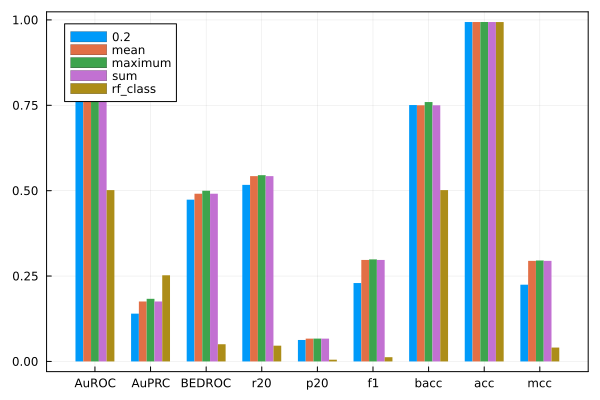

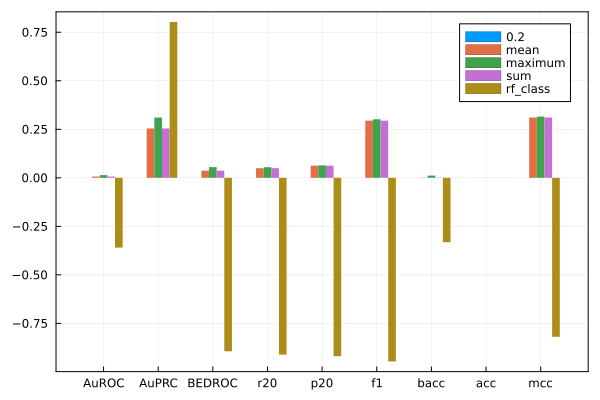

(nothing, 9×6 DataFrame
 Row │ metric  0.2        mean       maximum    sum        rf_class   
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?   
─────┼────────────────────────────────────────────────────────────────
   1 │ AuROC   0.783286   0.788326   0.794083   0.788326   0.50167
   2 │ AuPRC   0.13993    0.175512   0.183345   0.175512   0.252268
   3 │ BEDROC  0.473685   0.491081   0.49976    0.491081   0.0503431
   4 │ r20     0.517002   0.542592   0.545372   0.542592   0.0461262
   5 │ p20     0.0628364  0.0667702  0.0668737  0.0667702  0.00507246
   6 │ f1      0.229549   0.297174   0.298799   0.297174   0.0123974
   7 │ bacc    0.750781   0.750061   0.759519   0.750061   0.50167
   8 │ acc     0.993846   0.993862   0.993946   0.993862   0.993763
   9 │ mcc     0.224686   0.294465   0.295586   0.294465   0.0406123, 9×6 DataFrame
 Row │ metric  0.2       mean          maximum      sum           rf_class    
     │ String  Float64?  Float64?      Float64?     F

In [5]:
@iload RandomForestClassifier pkg=DecisionTree verbosity=0
# @iload XGBoostClassifier pkg=XGBoost verbosity=0

fxs = [mean, maximum, sum]

allmetrics(df, df_train, fxs, rf_class)

In [7]:
y, X =  machine_input(df, :Target); schema(X)

# X = coerce(X, :Target => MultiClass)

┌────────┬─────────────────┬────────────────────────────────────┐
│ names  │ scitypes        │ types                              │
├────────┼─────────────────┼────────────────────────────────────┤
│ Target │ Multiclass{395} │ CategoricalValue{String15, UInt32} │
│ 0.0    │ Continuous      │ Float64                            │
│ 0.05   │ Continuous      │ Float64                            │
│ 0.1    │ Continuous      │ Float64                            │
│ 0.15   │ Continuous      │ Float64                            │
│ 0.2    │ Continuous      │ Float64                            │
│ 0.25   │ Continuous      │ Float64                            │
│ 0.3    │ Continuous      │ Float64                            │
│ 0.35   │ Continuous      │ Float64                            │
│ 0.4    │ Continuous      │ Float64                            │
│ 0.45   │ Continuous      │ Float64                            │
│ 0.5    │ Continuous      │ Float64                            │
│ 0.55   │

In [8]:
yt, Xt =  machine_input(df_train, :Target, rng=123); schema(Xt)
# Xt = coerce(Xt, :Target => Multiclass)

┌────────┬─────────────────┬────────────────────────────────────┐
│ names  │ scitypes        │ types                              │
├────────┼─────────────────┼────────────────────────────────────┤
│ Target │ Multiclass{806} │ CategoricalValue{String15, UInt32} │
│ 0.0    │ Continuous      │ Float64                            │
│ 0.05   │ Continuous      │ Float64                            │
│ 0.1    │ Continuous      │ Float64                            │
│ 0.15   │ Continuous      │ Float64                            │
│ 0.2    │ Continuous      │ Float64                            │
│ 0.25   │ Continuous      │ Float64                            │
│ 0.3    │ Continuous      │ Float64                            │
│ 0.35   │ Continuous      │ Float64                            │
│ 0.4    │ Continuous      │ Float64                            │
│ 0.45   │ Continuous      │ Float64                            │
│ 0.5    │ Continuous      │ Float64                            │
│ 0.55   │

In [20]:
strip.(df[!, :Target])
dff = @chain df  begin
    DataFrames.transform(strip(:Target) => :Target)
end

LoadError: MethodError: no method matching strip(::Symbol)
[0mClosest candidates are:
[0m  strip(::Any, [91m::AbstractString[39m) at strings/util.jl:417
[0m  strip([91m::AbstractString[39m) at strings/util.jl:415
[0m  strip([91m::AbstractString[39m, [91m::Union{AbstractChar, Tuple{Vararg{AbstractChar}}, Set{<:AbstractChar}, AbstractVector{<:AbstractChar}}[39m) at strings/util.jl:416
[0m  ...

In [25]:
# filter_models(yt, Xt, 'c')
indexin(X[!, :Target], Xt[!, :Target])

190785-element Vector{Union{Nothing, Int64}}:
 1782
  487
   83
 1358
  372
  168
 1565
 2042
  705
     nothing
 1570
  728
  130
    ⋮
  266
 1406
  749
 1212
 1390
  708
 1869
  736
  432
  467
 1841
  489

In [26]:
setdiff(X[!, :Target], Xt[!, :Target])

9-element Vector{CategoricalArrays.CategoricalValue{String15, UInt32}}:
 String15("CHEMBL1293289")
 String15("CHEMBL1795186")
 String15("CHEMBL2527")
 String15("CHEMBL2808")
 String15("CHEMBL3473")
 String15("CHEMBL4015")
 String15("CHEMBL4093")
 String15("CHEMBL5137")
 String15("CHEMBL5533")

In [30]:
dfd = rescore(df_train)

Row,Ligando,Target,TP,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
,String15,String15,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,CHEMBL1000,CHEMBL1075102,0.0,0.000888101,0.00095427,0.00128082,0.00033433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CHEMBL1000,CHEMBL1075104,0.0,0.000771602,0.000823898,0.000998818,0.000382525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CHEMBL1000,CHEMBL1075132,0.0,0.00268097,0.00292532,0.00413533,0.00361053,0.00113057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CHEMBL1000,CHEMBL1075144,0.0,0.000894454,0.000968225,0.00117819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,CHEMBL1000,CHEMBL1075145,0.0,0.000893652,0.000971136,0.00206119,0.00199085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,CHEMBL1000,CHEMBL1075162,0.0,0.0017873,0.00196148,0.00347219,0.00922653,0.0359823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,CHEMBL1000,CHEMBL1075165,0.0,0.00266984,0.0028936,0.00416296,0.00388334,0.000228938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,CHEMBL1000,CHEMBL1075322,0.0,0.000893652,0.000978551,0.00167681,0.00437703,0.00455347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,CHEMBL1000,CHEMBL1075323,0.0,0.000892863,0.000981648,0.00156064,0.00253469,0.00113057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
filter(n -> n == "CHEMBL34", dfd[!, :Target])

String15[]

In [8]:
# OneHotEncoder = @iload OneHotEncoder pkg=MLJModels
DeterministicConstantClassifier = @iload DeterministicConstantClassifier pkg = MLJModels verbosity = 0
# RandomForestClassifier = @iload RandomForestClassifier pkg=DecisionTree verbosity=0
# DecisionTreeRegressor = @iload DecisionTreeRegressor pkg=DecisionTree verbosity = 0
# p1 = X -> coerce(X, :Target => OrderedFactor)
yt, Xt =  machine_input(df_train, :Target, rng=123)
# Xt = coerce(Xt, :Target => Multiclass)
# OneHot = OneHotEncoder()
# hot = machine(OneHot, Xt) |> fit!
# X = MLJ.transform(hot, Xt)
p2 = DeterministicConstantClassifier
dtm = machine(p2(), Xt, yt)
fit!(dtm)

# p1 = X -> 


[ Info: Training machine(DeterministicConstantClassifier(), …).


trained Machine; caches model-specific representations of data
  model: DeterministicConstantClassifier()
  args: 
    1:	Source @351 ⏎ Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{806}}}}
    2:	Source @256 ⏎ AbstractVector{Multiclass{2}}


In [10]:

# targets = categorical(X[!, :Target])
# X[!, :Target] = targets
y, X =  machine_input(df, :Target)
X = coerce(X, :Target => MultiClass)
yhat = MLJ.predict_mode(dtm, X)

LoadError: ArgumentError: CategoricalValue objects from unequal pools cannot be tested for order

In [12]:
fxs = [mean, maximum, sum]
dft = lin_transform(df, fxs, "0.2")
        
#         add predictions to df
dft[!, :rf_class] = yhat

190785-element CategoricalArrays.CategoricalArray{Float64,1,UInt32}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [14]:
dfe = evaluate(dft)

Row,groupid,AuROC,AuPRC,BEDROC,r20,p20,f1,bacc,acc,mcc
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.2,0.783286,0.13993,0.473685,0.517002,0.0628364,0.229549,0.750781,0.993846,0.224686
2,mean,0.788326,0.175512,0.491081,0.542592,0.0667702,0.297174,0.750061,0.993862,0.294465
3,maximum,0.794083,0.183345,0.49976,0.545372,0.0668737,0.298799,0.759519,0.993946,0.295586
4,sum,0.788326,0.175512,0.491081,0.542592,0.0667702,0.297174,0.750061,0.993862,0.294465
5,rf_class,0.50167,0.252268,0.0503431,0.0461262,0.00507246,0.0123974,0.50167,0.993763,0.0406123


In [44]:
# @iload OneHotEncoder pkg=MLJModels verbosity=0
@iload RandomForestClassifier pkg=DecisionTree verbosity=0
# @iload XGBoostClassifier pkg=XGBoost verbosity=0

fxs = [mean, maximum, sum]

allmetrics(df, df_train, fxs, rf_class, "0.2", false, true)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc DecisionTree.RandomForestClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{Union{AbstractVector{Continuous}, AbstractVector{Textual}}}, AbstractVector{Multiclass{2}}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:Union{AbstractVector{<:Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}}}, AbstractVector{<:Finite}}
└ @ ML

LoadError: TaskFailedException

[91m    nested task error: [39mOutOfMemoryError()
    Stacktrace:
      [1] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90m[4mboot.jl:461[24m[39m[90m [inlined][39m
      [2] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90m[4mboot.jl:469[24m[39m[90m [inlined][39m
      [3] [0m[1msimilar[22m
    [90m    @ [39m[90m./[39m[90m[4marray.jl:378[24m[39m[90m [inlined][39m
      [4] [0m[1msimilar[22m
    [90m    @ [39m[90m./[39m[90m[4msubarray.jl:65[24m[39m[90m [inlined][39m
      [5] [0m[1msimilar[22m
    [90m    @ [39m[90m./[39m[90m[4mabstractarray.jl:795[24m[39m[90m [inlined][39m
      [6] [0m[1m_unsafe_getindex[22m[0m[1m([22m::[0mIndexLinear, ::[0mSubArray[90m{Any, 2, Matrix{Any}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}}, true}[39m, ::[0mVector[90m{Int64}[39m, ::[0mBase.Slice[90m{Base.OneTo{Int64}}[39m[0m[1m)[22m
    [90m    @ [39m[90mBase[39m [90m./[39m[90m[4mmultidimensional.jl:887[24m[39m
      [7] [0m[1m_getindex[22m
    [90m    @ [39m[90m./[39m[90m[4mmultidimensional.jl:875[24m[39m[90m [inlined][39m
      [8] [0m[1mgetindex[22m
    [90m    @ [39m[90m./[39m[90m[4mabstractarray.jl:1241[24m[39m[90m [inlined][39m
      [9] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m~/.julia/packages/DecisionTree/HRuMd/src/classification/[39m[90m[4mmain.jl:491[24m[39m[90m [inlined][39m
     [10] [0m[1m(::DecisionTree.var"#87#threadsfor_fun#40"{DecisionTree.var"#87#threadsfor_fun#37#41"{Random._GLOBAL_RNG, Bool, SubArray{UInt32, 1, Vector{UInt32}, Tuple{Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Any, 2, Matrix{Any}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}}, true}, Int64, Int64, Int64, Float64, UInt64, DecisionTree.var"#36#39"{Vector{Float64}}, Vector{DecisionTree.Root{Any, UInt32}}, Int64, Int64, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[35mDecisionTree[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m
     [11] [0m[1m#87#threadsfor_fun[22m
    [90m    @ [39m[90m./[39m[90m[4mthreadingconstructs.jl:51[24m[39m[90m [inlined][39m
     [12] [0m[1m(::Base.Threads.var"#1#2"{DecisionTree.var"#87#threadsfor_fun#40"{DecisionTree.var"#87#threadsfor_fun#37#41"{Random._GLOBAL_RNG, Bool, SubArray{UInt32, 1, Vector{UInt32}, Tuple{Base.Slice{Base.OneTo{Int64}}}, true}, SubArray{Any, 2, Matrix{Any}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}}, true}, Int64, Int64, Int64, Float64, UInt64, DecisionTree.var"#36#39"{Vector{Float64}}, Vector{DecisionTree.Root{Any, UInt32}}, Int64, Int64, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:30[24m[39m

In [9]:
schema(X)

┌───────┬────────────────┬─────────────────────────────────┐
│ names │ scitypes       │ types                           │
├───────┼────────────────┼─────────────────────────────────┤
│ A     │ Continuous     │ Float64                         │
│ B     │ Multiclass{10} │ CategoricalValue{Int64, UInt32} │
└───────┴────────────────┴─────────────────────────────────┘


In [23]:
XGBoostClassifier = @iload XGBoostClassifier pkg=XGBoost verbosity=0
MLJ.fit_data_scitype(XGBoostClassifier)

Tuple{Table{<:AbstractVector{<:Continuous}}, AbstractVector{<:Finite}}

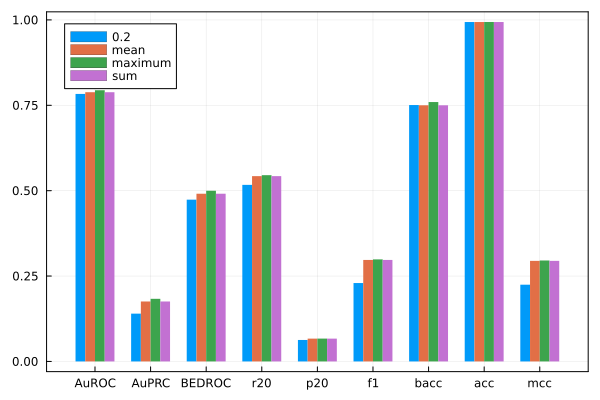

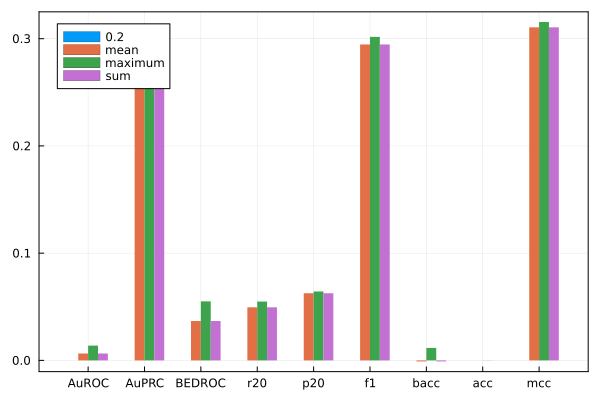

(0, 9×5 DataFrame
 Row │ metric  0.2        mean       maximum    sum       
     │ String  Float64?   Float64?   Float64?   Float64?  
─────┼────────────────────────────────────────────────────
   1 │ AuROC   0.783286   0.788326   0.794083   0.788326
   2 │ AuPRC   0.13993    0.175512   0.183345   0.175512
   3 │ BEDROC  0.473685   0.491081   0.49976    0.491081
   4 │ r20     0.517002   0.542592   0.545372   0.542592
   5 │ p20     0.0628364  0.0667702  0.0668737  0.0667702
   6 │ f1      0.229549   0.297174   0.298799   0.297174
   7 │ bacc    0.750781   0.750061   0.759519   0.750061
   8 │ acc     0.993846   0.993862   0.993946   0.993862
   9 │ mcc     0.224686   0.294465   0.295586   0.294465, 9×5 DataFrame
 Row │ metric  0.2       mean          maximum      sum          
     │ String  Float64?  Float64?      Float64?     Float64?     
─────┼───────────────────────────────────────────────────────────
   1 │ AuROC        0.0   0.00643421   0.0137839     0.00643421
   2 │ AuPRC  

In [86]:
# testing without model
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs)

In [9]:
 @iload LogisticClassifier pkg=MLJLinearModels verbosity=0
 @iload RandomForestClassifier pkg=DecisionTree verbosity=0

fxs = [mean, maximum, sum]
fxm = [log_class, rf_class]
allmetrics(df, df_train, fxs, fxm)

LoadError: OutOfMemoryError()

[ Info: Training machine(PCA(maxoutdim = 3, …), …).


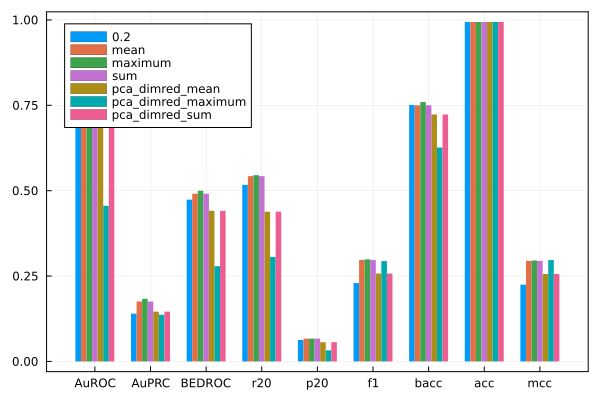

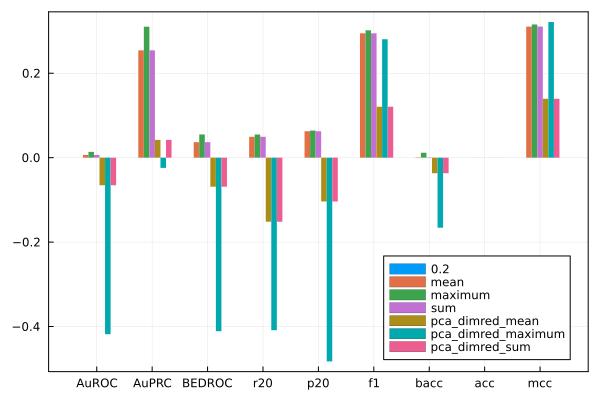

(9×8 DataFrame
 Row │ metric  0.2        mean       maximum    sum        pca_dimred_mean  pc ⋯
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?         Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ AuROC   0.783286   0.788326   0.794083   0.788326         0.732109      ⋯
   2 │ AuPRC   0.13993    0.175512   0.183345   0.175512         0.145825
   3 │ BEDROC  0.473685   0.491081   0.49976    0.491081         0.4411
   4 │ r20     0.517002   0.542592   0.545372   0.542592         0.438529
   5 │ p20     0.0628364  0.0667702  0.0668737  0.0667702        0.0563147     ⋯
   6 │ f1      0.229549   0.297174   0.298799   0.297174         0.257243
   7 │ bacc    0.750781   0.750061   0.759519   0.750061         0.72313
   8 │ acc     0.993846   0.993862   0.993946   0.993862         0.993883
   9 │ mcc     0.224686   0.294465   0.295586   0.294465         0.256039      ⋯
                                                          

In [76]:
@iload PCA pkg=MultivariateStats verbosity=0
fxs = [mean, maximum, sum]

all_metrics_dim(df, df_train, fxs, pca_dimred, "0.2", true; maxoutdim=3)



[ Info: Training machine(LinearRegressor(fit_intercept = true, …), …).
┌ Info: Solver: MLJLinearModels.Analytical
│   iterative: Bool false
└   max_inner: Int64 200


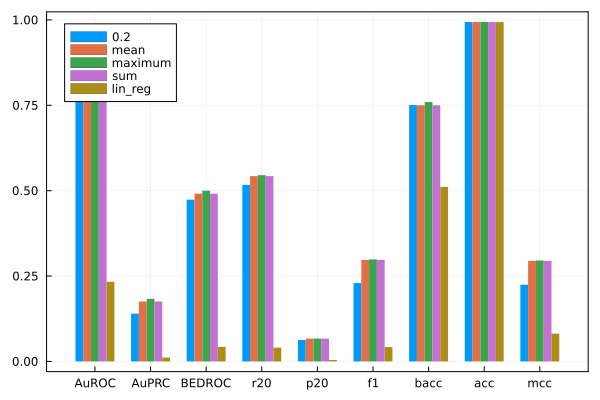

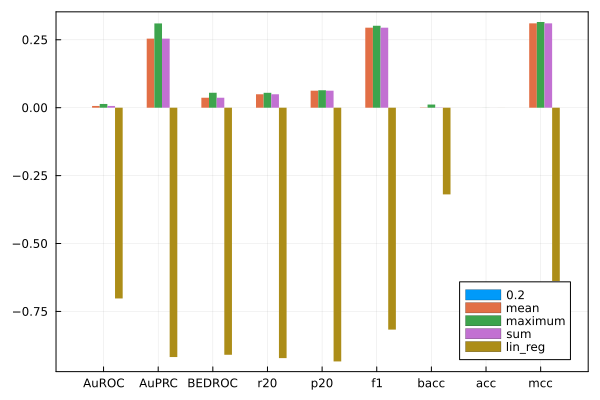

(MLJModelInterface.params, 9×6 DataFrame
 Row │ metric  0.2        mean       maximum    sum        lin_reg    
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?   
─────┼────────────────────────────────────────────────────────────────
   1 │ AuROC   0.783286   0.788326   0.794083   0.788326   0.233202
   2 │ AuPRC   0.13993    0.175512   0.183345   0.175512   0.0114788
   3 │ BEDROC  0.473685   0.491081   0.49976    0.491081   0.0428236
   4 │ r20     0.517002   0.542592   0.545372   0.542592   0.0403779
   5 │ p20     0.0628364  0.0667702  0.0668737  0.0667702  0.00414079
   6 │ f1      0.229549   0.297174   0.298799   0.297174   0.0420233
   7 │ bacc    0.750781   0.750061   0.759519   0.750061   0.511165
   8 │ acc     0.993846   0.993862   0.993946   0.993862   0.993763
   9 │ mcc     0.224686   0.294465   0.295586   0.294465   0.0813541, 9×6 DataFrame
 Row │ metric  0.2       mean          maximum      sum           lin_reg     
     │ String  Float64?  Float64?

In [13]:
@iload LinearRegressor pkg=MLJLinearModels verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, lin_reg, "0.2", true)

[ Info: Training machine(LinearRegressor(fit_intercept = true, …), …).
┌ Info: Solver: MLJLinearModels.Analytical
│   iterative: Bool false
└   max_inner: Int64 200
[ Info: Training machine(LassoRegressor(lambda = 1.0, …), …).
┌ Info: Solver: MLJLinearModels.ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
└   beta: Float64 0.8
[ Info: Training machine(RandomForestRegressor(max_depth = -1, …), …).


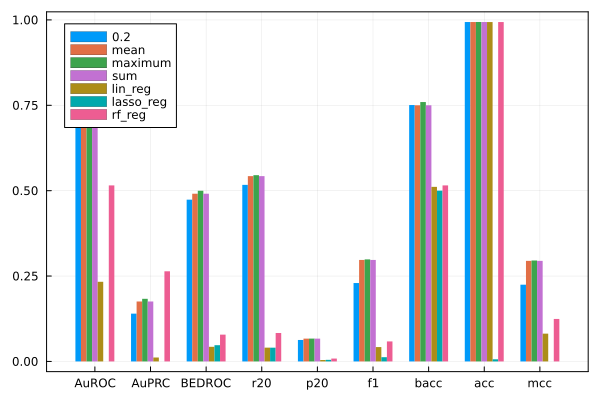

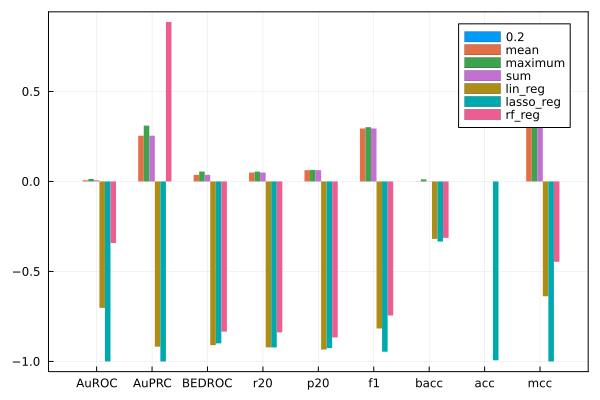

(MLJModelInterface.params, 9×8 DataFrame
 Row │ metric  0.2        mean       maximum    sum        lin_reg     lasso_r ⋯
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?    Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ AuROC   0.783286   0.788326   0.794083   0.788326   0.233202     0.0    ⋯
   2 │ AuPRC   0.13993    0.175512   0.183345   0.175512   0.0114788    0.0
   3 │ BEDROC  0.473685   0.491081   0.49976    0.491081   0.0428236    0.0475
   4 │ r20     0.517002   0.542592   0.545372   0.542592   0.0403779    0.0402
   5 │ p20     0.0628364  0.0667702  0.0668737  0.0667702  0.00414079   0.0046 ⋯
   6 │ f1      0.229549   0.297174   0.298799   0.297174   0.0420233    0.0123
   7 │ bacc    0.750781   0.750061   0.759519   0.750061   0.511165     0.5
   8 │ acc     0.993846   0.993862   0.993946   0.993862   0.993763     0.0062
   9 │ mcc     0.224686   0.294465   0.295586   0.294465   0.0813541   -3.0289 ⋯
     

In [14]:
@iload LinearRegressor pkg=MLJLinearModels verbosity=0
@iload LassoRegressor pkg=MLJLinearModels verbosity=0
@iload RandomForestRegressor pkg=DecisionTree verbosity=0

fxs = [mean, maximum, sum]
fxm = [lin_reg, lasso_reg, rf_reg]
allmetrics(df, df_train, fxs, fxm, "0.2", true)

[ Info: Training machine(PCA(maxoutdim = 5, …), …).
[ Info: Training machine(LinearRegressor(fit_intercept = true, …), …).
┌ Info: Solver: MLJLinearModels.Analytical
│   iterative: Bool false
└   max_inner: Int64 200
[ Info: Training machine(PCA(maxoutdim = 5, …), …).
[ Info: Training machine(LassoRegressor(lambda = 1.0, …), …).
┌ Info: Solver: MLJLinearModels.ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
└   beta: Float64 0.8
[ Info: Training machine(PCA(maxoutdim = 5, …), …).
[ Info: Training machine(RandomForestRegressor(max_depth = -1, …), …).


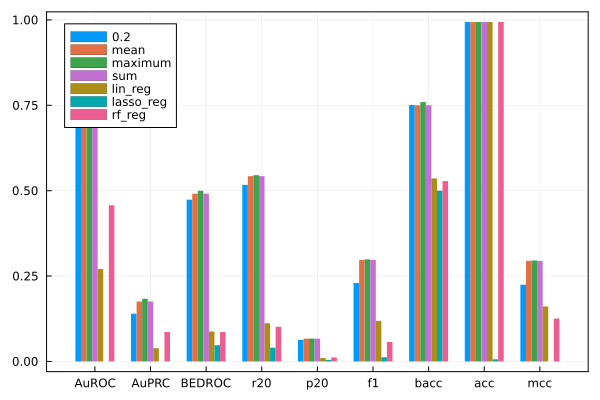

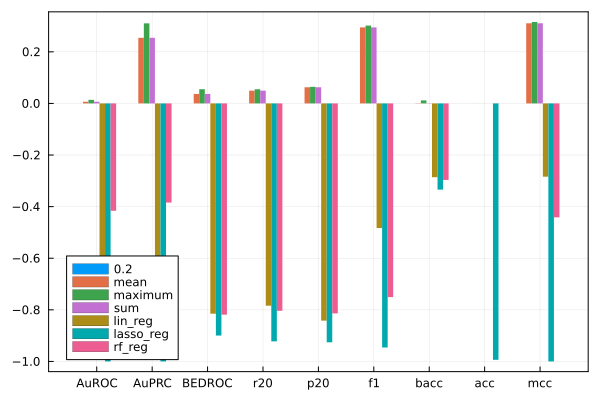

((forest = Ensemble of Decision Trees
Trees:      100
Avg Leaves: 477.87
Avg Depth:  21.79,), 9×8 DataFrame
 Row │ metric  0.2        mean       maximum    sum        lin_reg     lasso_r ⋯
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?    Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ AuROC   0.783286   0.788326   0.794083   0.788326   0.270581     0.0    ⋯
   2 │ AuPRC   0.13993    0.175512   0.183345   0.175512   0.0387547    0.0
   3 │ BEDROC  0.473685   0.491081   0.49976    0.491081   0.0876514    0.0475
   4 │ r20     0.517002   0.542592   0.545372   0.542592   0.111673     0.0402
   5 │ p20     0.0628364  0.0667702  0.0668737  0.0667702  0.00993789   0.0046 ⋯
   6 │ f1      0.229549   0.297174   0.298799   0.297174   0.118644     0.0123
   7 │ bacc    0.750781   0.750061   0.759519   0.750061   0.536018     0.5
   8 │ acc     0.993846   0.993862   0.993946   0.993862   0.993815     0.0062
   9 │ mcc     0.22

In [26]:
@iload PCA pkg=MultivariateStats verbosity=0
@iload LinearRegressor pkg=MLJLinearModels verbosity=0
@iload LassoRegressor pkg=MLJLinearModels verbosity=0
@iload RandomForestRegressor pkg=DecisionTree verbosity=0

fxs = [mean, maximum, sum]
fxm = [lin_reg, lasso_reg, rf_reg]
allmetrics(df, df_train, fxs, fxm, "0.2", pca_dimred, true)

In [12]:
filter_models(df, "logistic")

1-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = LogisticClassifier, package_name = MLJLinearModels, ... )

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


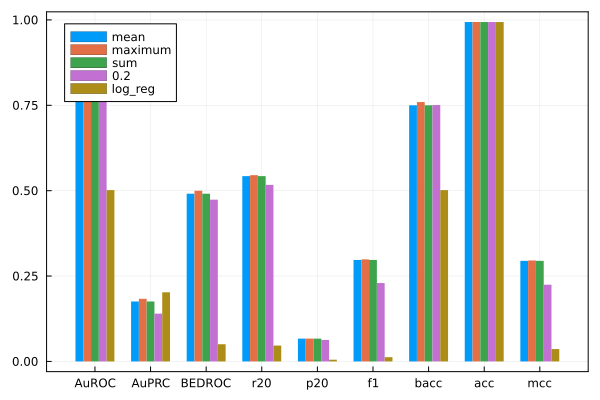

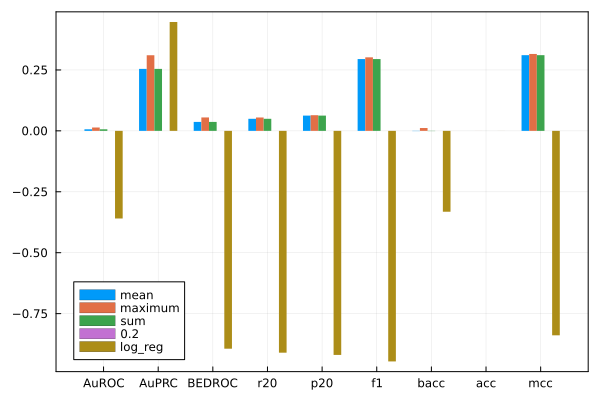

(MLJModelInterface.params, 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        log_reg    
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?   
─────┼────────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.501665
   2 │ AuPRC   0.175512   0.183345   0.175512   0.13993    0.202436
   3 │ BEDROC  0.491081   0.49976    0.491081   0.473685   0.0503331
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.0464713
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.00507246
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.0123974
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.501665
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.993752
   9 │ mcc     0.294465   0.295586   0.294465   0.224686   0.0362102, 9×6 DataFrame
 Row │ metric  mean          maximum      sum           0.2       log_reg     
     │ String  Float64?      Float

In [20]:
@load LogisticClassifier pkg=MLJLinearModels verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, log_reg, "0.2", penalty = :none)

In [18]:
# search for models compatible with datatypes, is native julia and based on keyword
filter(
#     check for pure julia models
    m -> m.is_pure_julia && 
             contains(m.docstring * m.name, "Forest"),
    compatible_models
)

2-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = RandomForestClassifier, package_name = BetaML, ... )
 (name = RandomForestClassifier, package_name = DecisionTree, ... )

[ Info: Training machine(RandomForestClassifier(max_depth = -1, …), …).


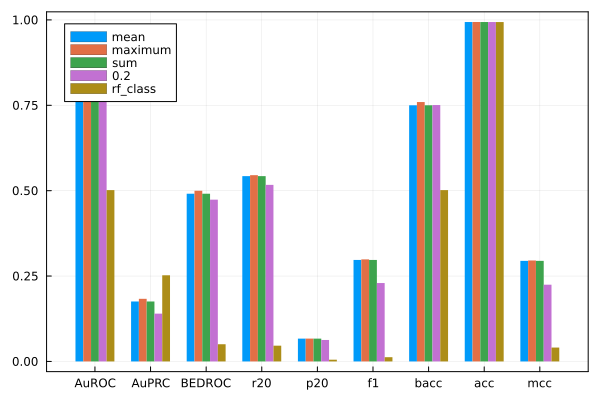

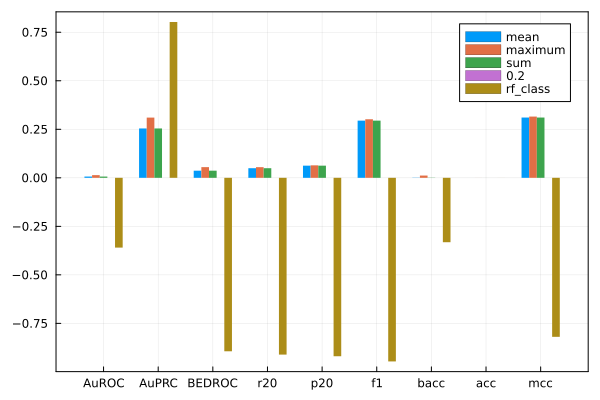

((forest = Ensemble of Decision Trees
Trees:      1000
Avg Leaves: 368.506
Avg Depth:  23.221,), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        rf_class   
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?   
─────┼────────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.50167
   2 │ AuPRC   0.175512   0.183345   0.175512   0.13993    0.252268
   3 │ BEDROC  0.491081   0.49976    0.491081   0.473685   0.0503431
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.0461262
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.00507246
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.0123974
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.50167
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.993763
   9 │ mcc     0.294465   0.295586   0.294465   0.224686   0.0406123, 9×6 DataFrame
 Row │ metric  mean          maximum      sum

In [19]:
# Rnadom Forest Classifier model
@iload RandomForestClassifier pkg=DecisionTree verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, rf_class, "0.2"; n_trees=1000)

In [105]:
# Rnadom Forest Classifier model; sklearn version; imbalanced Hyper-parameter balancing subsamples
@iload RandomForestClassifier pkg=MLJScikitLearnInterface verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, sklearn_rf_class, "0.2", class_weight = "balanced_subsample")

[ Info: Training machine(RandomForestClassifier(n_estimators = 100, …), …).


LoadError: BoundsError: attempt to access data frame with 24 columns at index [4:25]

In [21]:
@iload RandomForestClassifier pkg=DecisionTree verbosity=0
fxs = [mean, maximum, sum]
rft_df, param = train_rescore(df, df_train, fxs, rf_class)
rft_df[1:10, 3:end]


[ Info: Training machine(RandomForestClassifier(max_depth = -1, …), …).


Row,TP,0.2,mean,maximum,sum,rf_class
,Float64,Float64?,Float64?,Float64?,Float64?,Cat…
1,0.0,0.0,4.71153e-6,5.02698e-5,9.89422e-5,0.0
2,0.0,0.0,5.89425e-7,5.72355e-6,1.23779e-5,0.0
3,0.0,0.0,2.49448e-6,2.20103e-5,5.23842e-5,0.0
4,0.0,0.0,1.24007e-6,9.3893e-6,2.60415e-5,0.0
5,0.0,0.0,5.41803e-6,4.35057e-5,0.000113779,0.0
6,0.0,0.0,3.27955e-6,5.37322e-5,6.88706e-5,0.0
7,0.0,0.0,2.21683e-6,1.6584e-5,4.65534e-5,0.0
8,0.0,0.0,6.18155e-6,5.93017e-5,0.000129813,0.0
9,0.0,0.0,3.9174e-6,3.11141e-5,8.22653e-5,0.0


In [22]:
df2 = evaluate(rft_df, fxs, rf_class)


Row,groupid,AuROC,AuPRC,BEDROC,r20,p20,f1,bacc,acc,mcc
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,mean,0.788326,0.175512,0.491081,0.542592,0.0667702,0.297174,0.750061,0.993862,0.294465
2,maximum,0.794083,0.183345,0.49976,0.545372,0.0668737,0.298799,0.759519,0.993946,0.295586
3,sum,0.788326,0.175512,0.491081,0.542592,0.0667702,0.297174,0.750061,0.993862,0.294465
4,0.2,0.783286,0.13993,0.473685,0.517002,0.0628364,0.229549,0.750781,0.993846,0.224686
5,rf_class,0.50167,0.252268,0.0503431,0.0461262,0.00507246,0.0123974,0.50167,0.993763,0.0406123


In [23]:
plot1, plot2, df_plot, df_perct = plotmetrics(df2)

(Plot{Plots.GRBackend() n=5}, Plot{Plots.GRBackend() n=5}, 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        rf_class   
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?   
─────┼────────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.50167
   2 │ AuPRC   0.175512   0.183345   0.175512   0.13993    0.252268
   3 │ BEDROC  0.491081   0.49976    0.491081   0.473685   0.0503431
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.0461262
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.00507246
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.0123974
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.50167
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.993763
   9 │ mcc     0.294465   0.295586   0.294465   0.224686   0.0406123, 9×6 DataFrame
 Row │ metric  mean          maximum      sum           0.2       rf_class    
    

[ Info: Training machine(RandomForestClassifier(max_depth = 10, …), …).


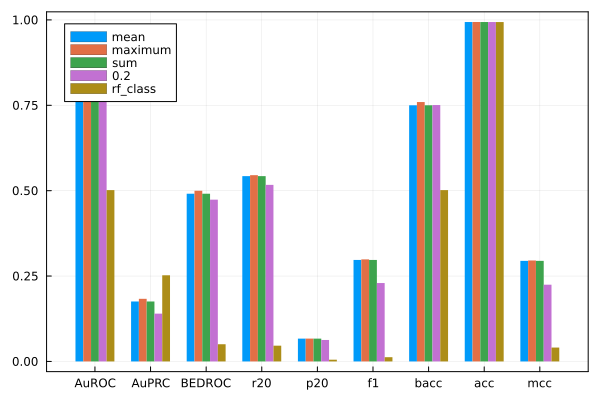

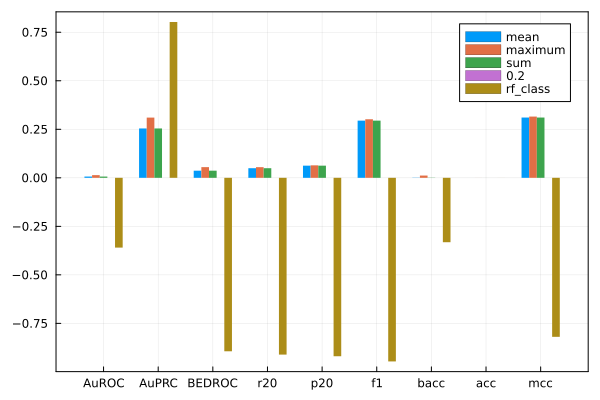

((forest = Ensemble of Decision Trees
Trees:      100
Avg Leaves: 162.77
Avg Depth:  10.0,), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        rf_class   
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?   
─────┼────────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.50167
   2 │ AuPRC   0.175512   0.183345   0.175512   0.13993    0.252268
   3 │ BEDROC  0.491081   0.49976    0.491081   0.473685   0.0503431
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.0461262
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.00507246
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.0123974
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.50167
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.993763
   9 │ mcc     0.294465   0.295586   0.294465   0.224686   0.0406123, 9×6 DataFrame
 Row │ metric  mean          maximum      sum    

In [24]:
# Rnadom Forest Classifier model; max tree depth = 10
@iload RandomForestClassifier pkg=DecisionTree verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, rf_class, "0.2", max_depth = 10)

In [25]:
filter(
#     check for pure julia models
    m -> m.is_pure_julia && 
             contains(m.docstring * m.name, "XGBoost"),
    compatible_models
)

NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}[]

[ Info: Training machine(XGBoostClassifier(test = 1, …), …).
[ Info: XGBoost: starting training.
[ Info: [1]	train-logloss:0.43811215912336926
[ Info: [2]	train-logloss:0.29723195074581049
[ Info: [3]	train-logloss:0.20846369806223358
[ Info: [4]	train-logloss:0.14906013994798784
[ Info: [5]	train-logloss:0.10795153038957117
[ Info: [6]	train-logloss:0.07889302434027963
[ Info: [7]	train-logloss:0.05806155779355582
[ Info: [8]	train-logloss:0.04300037888797514
[ Info: [9]	train-logloss:0.03202238397757251
[ Info: [10]	train-logloss:0.02398841784658621
[ Info: [11]	train-logloss:0.01808547770140565
[ Info: [12]	train-logloss:0.01374522392956640
[ Info: [13]	train-logloss:0.01053736201481398
[ Info: [14]	train-logloss:0.00817485653593866
[ Info: [15]	train-logloss:0.00641676919023152
[ Info: [16]	train-logloss:0.00511371046687504
[ Info: [17]	train-logloss:0.00414515752712833
[ Info: [18]	train-logloss:0.00342248422887057
[ Info: [19]	train-logloss:0.00288827537363638
[ Info: [20]	train-

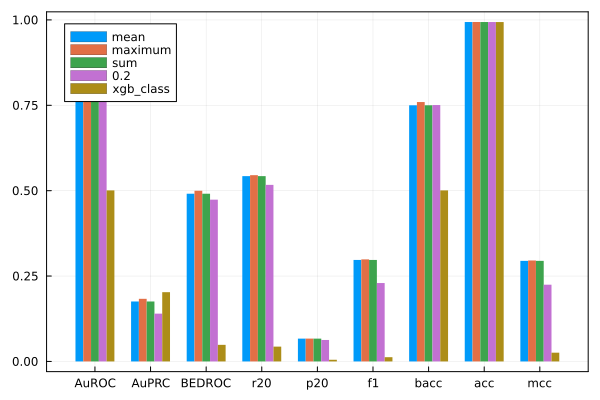

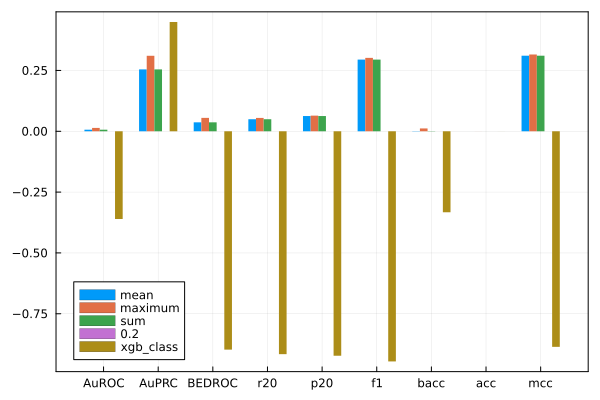

((fitresult = (XGBoost.Booster(), CategoricalArrays.CategoricalValue{Float64, UInt32} 0.0),), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        xgb_class  
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?   
─────┼────────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.500832
   2 │ AuPRC   0.175512   0.183345   0.175512   0.13993    0.202777
   3 │ BEDROC  0.491081   0.49976    0.491081   0.473685   0.0485714
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.0433657
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.00486542
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.0123974
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.500832
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.993757
   9 │ mcc     0.294465   0.295586   0.294465   0.224686   0.0256042, 9×6 DataFrame
 Row │ metric  mean          maximum      sum 

In [26]:
@iload XGBoostClassifier pkg=XGBoost verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, xgb_class, "0.2")

In [27]:
PCA = @iload PCA pkg=MultivariateStats verbosity=0

y, X = machine_input(df_train)

model = PCA(maxoutdim=5)
mach = machine(model, X) |> fit!

Xproj = MLJ.transform(mach, X)



[ Info: Training machine(PCA(maxoutdim = 5, …), …).


Row,x1,x2,x3
,Float64,Float64,Float64
1,0.0233243,-0.00590629,0.00429616
2,0.0233304,-0.00598846,0.00442771
3,0.0228247,-0.00248194,0.00116615
4,0.0233497,-0.00608173,0.0044434
5,0.0231909,-0.00495382,0.00345103
6,0.0174896,0.0200269,-0.00438554
7,0.0229344,-0.00288277,0.00117868
8,0.0223826,-0.00128176,0.00216392
9,0.0230027,-0.00415885,0.00327383


In [29]:
# Add dimensionality reduction and the the ensemble model

[ Info: Training machine(PCA(maxoutdim = 5, …), …).
[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


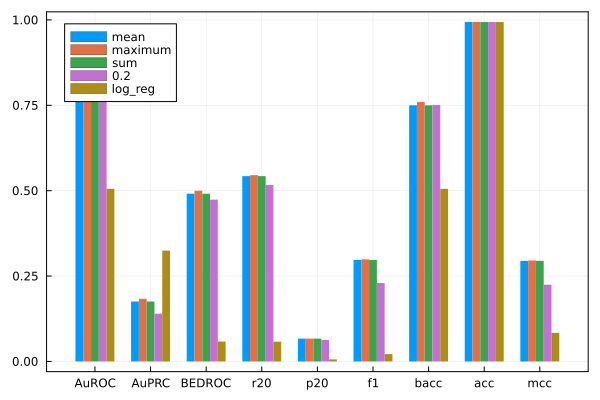

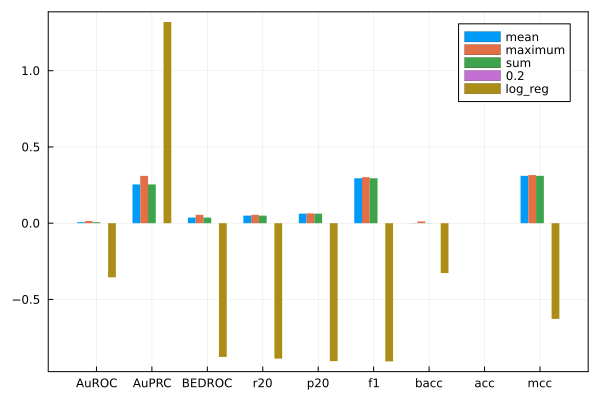

((classes = CategoricalArrays.CategoricalValue{Float64, UInt32}[0.0, 1.0], coefs = [:x1 => -6.29559377136553, :x2 => -10.956993537091572, :x3 => -0.9121851483974341], intercept = -8.312063120170532), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        log_reg    
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?   
─────┼────────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.505444
   2 │ AuPRC   0.175512   0.183345   0.175512   0.13993    0.324534
   3 │ BEDROC  0.491081   0.49976    0.491081   0.473685   0.0582949
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.0578585
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.00600414
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.0214876
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.505444
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.993794
   9 │ mcc     0.294465 

In [30]:
@iload PCA pkg=MultivariateStats verbosity=0
@load LogisticClassifier pkg=MLJLinearModels verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, log_reg, "0.2", pca_dimred)
# train_rescore(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, model="0", benchmark::String="0.2", fxd=nothing; args...)

[ Info: Training machine(PCA(maxoutdim = 5, …), …).
[ Info: Training machine(RandomForestClassifier(max_depth = -1, …), …).


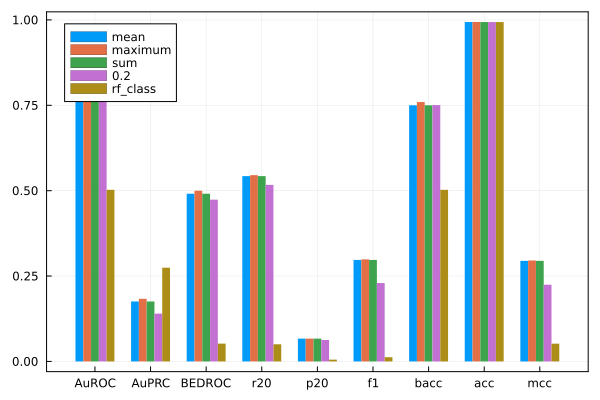

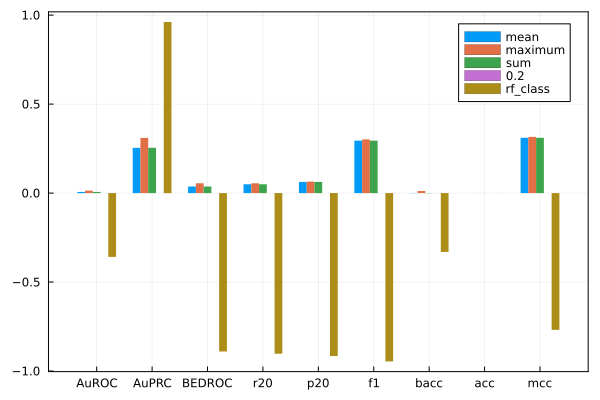

((forest = Ensemble of Decision Trees
Trees:      100
Avg Leaves: 459.04
Avg Depth:  25.46,), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        rf_class  
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?  
─────┼───────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.502508
   2 │ AuPRC   0.175512   0.183345   0.175512   0.13993    0.274455
   3 │ BEDROC  0.491081   0.49976    0.491081   0.473685   0.0521145
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.050267
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.0052795
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.0123974
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.502508
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.993768
   9 │ mcc     0.294465   0.295586   0.294465   0.224686   0.0520065, 9×6 DataFrame
 Row │ metric  mean          maximum      sum      

In [6]:
@iload PCA pkg=MultivariateStats verbosity=0
@iload RandomForestClassifier pkg=DecisionTree verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, rf_class, "0.2", pca_dimred)

[ Info: Training machine(PCA(maxoutdim = 5, …), …).
[ Info: Training machine(XGBoostClassifier(test = 1, …), …).
[ Info: XGBoost: starting training.
[ Info: [1]	train-logloss:0.43815276938077885
[ Info: [2]	train-logloss:0.29730765679298776
[ Info: [3]	train-logloss:0.20856610679820262
[ Info: [4]	train-logloss:0.14920440934615278
[ Info: [5]	train-logloss:0.10812974569846873
[ Info: [6]	train-logloss:0.07908879918159666
[ Info: [7]	train-logloss:0.05828357697463905
[ Info: [8]	train-logloss:0.04323228340778950
[ Info: [9]	train-logloss:0.03227298390895190
[ Info: [10]	train-logloss:0.02425300680745448
[ Info: [11]	train-logloss:0.01836436013300912
[ Info: [12]	train-logloss:0.01402863058594921
[ Info: [13]	train-logloss:0.01083383758325947
[ Info: [14]	train-logloss:0.00847386310717808
[ Info: [15]	train-logloss:0.00673280020348132
[ Info: [16]	train-logloss:0.00544188879630708
[ Info: [17]	train-logloss:0.00448036871003094
[ Info: [18]	train-logloss:0.00376999020235333
[ Info: [19]	t

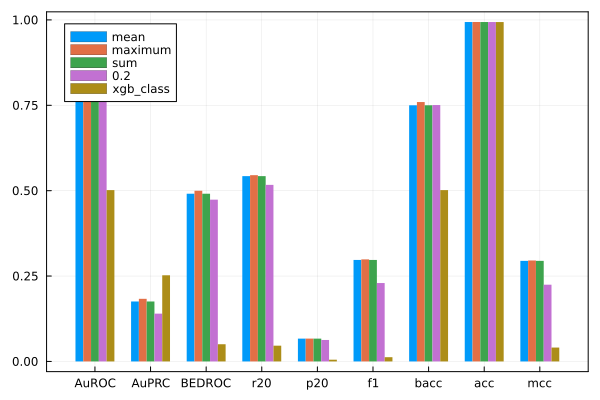

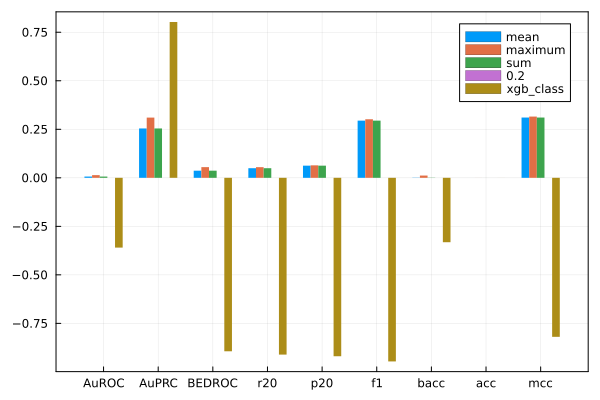

((fitresult = (XGBoost.Booster(), CategoricalArrays.CategoricalValue{Float64, UInt32} 0.0),), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        xgb_class  
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?   
─────┼────────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.50167
   2 │ AuPRC   0.175512   0.183345   0.175512   0.13993    0.252268
   3 │ BEDROC  0.491081   0.49976    0.491081   0.473685   0.0503431
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.0461262
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.00507246
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.0123974
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.50167
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.993763
   9 │ mcc     0.294465   0.295586   0.294465   0.224686   0.0406123, 9×6 DataFrame
 Row │ metric  mean          maximum      sum   

In [7]:
@iload PCA pkg=MultivariateStats verbosity=0
@iload XGBoostClassifier pkg=XGBoost verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, xgb_class, "0.2", pca_dimred)

In [7]:
@iload RandomForestClassifier pkg=DecisionTree verbosity=0
y, y_hat = machine_train_predict(df, df_train, rf_class)


[ Info: Training machine(RandomForestClassifier(max_depth = -1, …), …).


(CategoricalArrays.CategoricalValue{Float64, UInt32}[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], CategoricalArrays.CategoricalValue{Float64, UInt32}[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [13]:
mcc_rf = MLJ.mcc(y_hat, y)
f1_rf = MLJ.f1score(y_hat, y)

┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase ~/.julia/packages/MLJBase/WKVEo/src/measures/confusion_matrix.jl:116


0.00667779632721202

In [14]:
confmat(y_hat, y)

┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase ~/.julia/packages/MLJBase/WKVEo/src/measures/confusion_matrix.jl:116


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │   189591    │    1186     │
├─────────────┼─────────────┼─────────────┤
│     1.0     │      4      │      4      │
└─────────────┴─────────────┴─────────────┘


In [52]:
function test_machine_train_predict(df, df_train, model; args...)

     y, X =  machine_input(df)

    # train machine and get parameters
    m1 = machine(model) |> fit!
    yhat = MLJBase.transform(m1, y, X)

    return yhat
end

test_machine_train_predict (generic function with 1 method)

In [57]:
function test_train_rescore(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, model::Vector, benchmark::String="0.2", isreg=false; args...)
  
    dft = lin_transform(df, fxs, benchmark)
    if model !== nothing
        for m in model
    #     train machine and make predictions
            if isreg == true
                _, yhat, params = regressor_machine_train_predict(df, df_train, m; args...)
            else
                yhat = test_machine_train_predict(df, df_train, m; args...)
            end
            m_name = String(Symbol(m))
            dft[!, m_name] = yhat
        end
    else
        dft = lin_transform(df, fxs, benchmark)
    end
    return dft
end

test_train_rescore (generic function with 7 methods)

In [54]:
mutable struct ef_function <: Static
    f::Function
end

using MLJBase
MLJBase.transform(a::ef_function, _, y, X) = a.f.(eachrow(Matrix(X)))

In [58]:
dft = test_train_rescore(df, df_train, fxs, [ef_function(maximum)])

[ Info: Training machine(ef_function(f = maximum), …).


Row,Ligando,Target,TP,0.2,mean,maximum,sum,ef_function(f = maximum)
,String15,String15,Float64,Float64?,Float64?,Float64?,Float64?,Float64
1,CHEMBL1062,CHEMBL1075132,0.0,0.0,4.71153e-6,5.02698e-5,9.89422e-5,5.02698e-5
2,CHEMBL1062,CHEMBL1075145,0.0,0.0,5.89425e-7,5.72355e-6,1.23779e-5,5.72355e-6
3,CHEMBL1062,CHEMBL1075165,0.0,0.0,2.49448e-6,2.20103e-5,5.23842e-5,2.20103e-5
4,CHEMBL1062,CHEMBL1075323,0.0,0.0,1.24007e-6,9.3893e-6,2.60415e-5,9.3893e-6
5,CHEMBL1062,CHEMBL1163125,0.0,0.0,5.41803e-6,4.35057e-5,0.000113779,4.35057e-5
6,CHEMBL1062,CHEMBL1250378,0.0,0.0,3.27955e-6,5.37322e-5,6.88706e-5,5.37322e-5
7,CHEMBL1062,CHEMBL1293224,0.0,0.0,2.21683e-6,1.6584e-5,4.65534e-5,1.6584e-5
8,CHEMBL1062,CHEMBL1293226,0.0,0.0,6.18155e-6,5.93017e-5,0.000129813,5.93017e-5
9,CHEMBL1062,CHEMBL1293267,0.0,0.0,3.9174e-6,3.11141e-5,8.22653e-5,3.11141e-5


In [59]:
evaluate(dft)

Row,groupid,AuROC,AuPRC,BEDROC,r20,p20,f1,bacc,acc,mcc
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.2,0.783286,0.13993,0.473685,0.517002,0.0628364,0.229549,0.750781,0.993846,0.224686
2,mean,0.788326,0.175512,0.491081,0.542592,0.0667702,0.297174,0.750061,0.993862,0.294465
3,maximum,0.794083,0.183345,0.49976,0.545372,0.0668737,0.298799,0.759519,0.993946,0.295586
4,sum,0.788326,0.175512,0.491081,0.542592,0.0667702,0.297174,0.750061,0.993862,0.294465
5,ef_function(f = maximum),0.794083,0.183345,0.49976,0.545372,0.0668737,0.298799,0.759519,0.993946,0.295586


In [ ]:
allmetrics(df, df_train, [maximum], [maximum], "0.2", pca_dimred)

In [27]:
y, X = machine_input(df)


(CategoricalArrays.CategoricalValue{Float64, UInt32}[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 190785×21 DataFrame
    Row │ 0.0         0.05         0.1          1.5         0.2         2.5    ⋯
        │ Float64     Float64      Float64      Float64     Float64     Float6 ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ 2.27353e-5  2.49703e-5   5.02698e-5   9.6681e-7   0.0             0. ⋯
      2 │ 5.10256e-6  5.72355e-6   1.55182e-6   0.0         0.0             0.
      3 │ 2.16946e-5  2.20103e-5   8.6793e-6    0.0         0.0             0.
      4 │ 9.05151e-6  9.3893e-6    6.63393e-6   9.6681e-7   0.0             0.
      5 │ 4.21232e-5  4.35057e-5   2.71583e-5   9.91379e-7  0.0             0. ⋯
      6 │ 6.50849e-6  8.62989e-6   5.37322e-5   0.0         0.0             0.
      7 │ 1.6584e-5   1.61176e-5   1.38519e-5   0.0         0.0             0.
      8 │ 2.15297e-5  2